In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


  1%|▌                                        | 18/1283 [00:01<01:50, 11.40it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|███████▌                               | 248/1283 [00:02<00:09, 114.80it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 22%|████████▌                              | 281/1283 [00:02<00:06, 153.80it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 23%|█████████                              | 300/1283 [00:03<00:07, 131.21it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 28%|██████████▉                            | 359/1283 [00:03<00:06, 138.05it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 32%|████████████▊                           | 409/1283 [00:04<00:09, 94.45it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|█████████████████▉                     | 590/1283 [00:05<00:04, 171.90it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

 56%|█████████████████████▉                 | 723/1283 [00:06<00:03, 148.93it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 84%|███████████████████████████████▊      | 1074/1283 [00:08<00:00, 254.90it/s]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████| 1283/1283 [00:10<00:00, 119.48it/s]


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = human_lombardo['smiles_r']
Mordred_table

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     26.726479  20.199330    2.0    0.0  43.712035  2.420516  4.841033   
1     16.484101  15.092007    1.0    0.0  24.810570  2.476291  4.952581   
2     30.181133  23.132813    4.0    0.0  49.053928  2.449016  4.898018   
3     10.077834   9.321842    0.0    1.0  17.214150  2.226811  4.453621   
4     14.384684  13.322169    0.0    0.0  23.623048  2.530742  4.897943   
...         ...        ...    ...    ...        ...       ...       ...   
1278  12.606602  10.129166    0.0    1.0  22.084432  2.412947  4.825894   
1279  14.018917  11.675935    0.0    1.0  24.741115  2.478172  4.956344   
1280  16.038187  14.420804    0.0    2.0  27.701443  2.658726  5.024986   
1281  15.515909  12.987974    0.0    2.0  26.938755  2.326623  4.635214   
1282  11.939935   9.906091    0.0    2.0  20.559285  2.387450  4.754235   

         SpAD_A   SpMAD_A   LogEE_A  ...     TSRW10          MW       AMW  \
0     43.712035  1.248915  4.459804  ...  71.132315  475.161514  8.485027   
1     24.810570  1.127753  3.981521  ...  56.111877  299.201654  6.106156   
2     49.053928  1.257793  4.581296  ...  89.010877  529.176450  8.675024   
3     17.214150  1.229582  3.514311  ...  44.372474  188.143376  5.879480   
4     23.623048  1.243318  3.870813  ...  67.418049  267.085521  8.346423   
...         ...       ...       ...  ...        ...         ...       ...   
1278  22.084432  1.380277  3.723828  ...  48.647579  221.128454  6.700862   
1279  24.741115  1.374506  3.833767  ...  51.418286  244.205976  5.550136   
1280  27.701443  1.385072  3.997563  ...  75.593926  263.154275  6.747546   
1281  26.938755  1.346938  3.923960  ...  66.060685  266.165174  6.654129   
1282  20.559285  1.370619  3.669040  ...  60.402256  205.097154  7.324898   

       WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  \
0     4344.0  54.0    176.0    202.0  13.083333  7.805556   
1     1036.0  34.0    110.0    125.0  11.180556  4.750000   
2     5657.0  62.0    202.0    236.0  13.805556  8.611111   
3      337.0  16.0     62.0     67.0   5.333333  3.361111   
4      654.0  34.0    100.0    122.0   8.229167  4.291667   
...      ...   ...      ...      ...        ...       ...   
1278   412.0  24.0     84.0     99.0   3.444444  3.583333   
1279   549.0  29.0     94.0    112.0   4.034722  4.083333   
1280   751.0  30.0    112.0    139.0   4.256944  4.402778   
1281   829.0  24.0    100.0    113.0   4.444444  4.527778   
1282   359.0  20.0     80.0     94.0   3.194444  3.305556   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 1614 columns]

In [10]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

441

In [11]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
Morganfingerprint_table

Mfp0  Mfp1  Mfp2  Mfp3  Mfp4  Mfp5  Mfp6  Mfp7  Mfp8  Mfp9  ...  \
0        0     1     0     0     0     0     0     0     0     0  ...   
1        0     0     0     0     0     0     0     0     0     0  ...   
2        0     1     0     0     0     0     0     0     0     0  ...   
3        0     1     0     0     1     0     0     0     0     0  ...   
4        0     0     0     0     0     0     0     0     0     0  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
1278     0     0     0     0     0     0     0     0     0     0  ...   
1279     0     0     1     0     0     0     0     0     0     0  ...   
1280     0     0     0     0     0     0     0     0     0     0  ...   
1281     0     0     0     0     0     0     0     0     0     0  ...   
1282     0     0     0     0     0     0     0     0     0     0  ...   

      Mfp2039  Mfp2040  Mfp2041  Mfp2042  Mfp2043  Mfp2044  Mfp2045  Mfp2046  \
0           0        0        0        0        0        0        0        0   
1           0        0        0        0        0        0        0        0   
2           0        0        0        0        0        0        0        0   
3           0        0        0        0        0        0        0        0   
4           0        0        0        1        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
1278        0        0        0        0        0        0        0        0   
1279        0        0        0        0        0        0        0        0   
1280        0        0        0        0        0        0        0        0   
1281        0        0        0        0        0        0        0        0   
1282        0        0        0        0        0        0        0        0   

      Mfp2047                                           smiles_r  
0           0  C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1           0      C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2           0  C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3           0                          C#CC[NH+](C)C(C)Cc1ccccc1  
4           0  C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...       ...                                                ...  
1278        0                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279        0                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280        0              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281        0                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282        0                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 2049 columns]

In [12]:
human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
human_lombardo_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle
def predict_animal(data, endpoint, animal):#log human_VDss_L_kg model
    
    #Read columns needed for animal data
    file = open(f"features_mfp_mordred_columns_{animal}_model.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]

    loaded_rf = pickle.load(open(f"log_{endpoint}_model_FINAL.sav", 'rb'))

    X = data[features]
    #Replace missing descriptors with median

    imp=SimpleImputer(missing_values=np.nan, strategy='median')
    X_new=pd.DataFrame(imp.fit_transform(X))
    X_new.columns=X.columns
    X_new.index=X.index
    
    # Load the scaler from the file
    with open(f'scaler_{animal}.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Scale the features using the loaded scaler
    X_new = scaler.transform(X_new)
    X_new = pd.DataFrame(X_new, columns=features)
    

    y_pred =  loaded_rf.predict(X_new)   

    return(y_pred)

In [14]:
human_lombardo_mfp_Mordred_animal = human_lombardo_mfp_Mordred
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0        0  ...  10.345445  71.132315  475.161514  8.485027  4344.0  54.0   
1        0  ...  10.048237  56.111877  299.201654  6.106156  1036.0  34.0   
2        0  ...  10.533295  89.010877  529.176450  8.675024  5657.0  62.0   
3        0  ...   8.987072  44.372474  188.143376  5.879480   337.0  16.0   
4        0  ...  10.060961  67.418049  267.085521  8.346423   654.0  34.0   
...    ...  ...        ...        ...         ...       ...     ...   ...   
1278     0  ...   9.706073  48.647579  221.128454  6.700862   412.0  24.0   
1279     0  ...   9.934065  51.418286  244.205976  5.550136   549.0  29.0   
1280     0  ...  10.245906  75.593926  263.154275  6.747546   751.0  30.0   
1281     0  ...   9.582249  66.060685  266.165174  6.654129   829.0  24.0   
1282     0  ...   9.585003  60.402256  205.097154  7.324898   359.0  20.0   

      Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0       176.0    202.0  13.083333  7.805556  
1       110.0    125.0  11.180556  4.750000  
2       202.0    236.0  13.805556  8.611111  
3        62.0     67.0   5.333333  3.361111  
4       100.0    122.0   8.229167  4.291667  
...       ...      ...        ...       ...  
1278     84.0     99.0   3.444444  3.583333  
1279     94.0    112.0   4.034722  4.083333  
1280    112.0    139.0   4.256944  4.402778  
1281    100.0    113.0   4.444444  4.527778  
1282     80.0     94.0   3.194444  3.305556  

[1283 rows x 3667 columns]

In [15]:
endpoints = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "dog") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

dog_VDss_L_kg
dog_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


dog_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [16]:
endpoints = ["monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "monkey") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


monkey_VDss_L_kg
monkey_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


monkey_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
endpoints = ["rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

for endpoint in endpoints:
    print(endpoint)
    preds = predict_animal(human_lombardo_mfp_Mordred_animal, endpoint, "rat") 
    human_lombardo_mfp_Mordred_animal[endpoint] = preds

rat_VDss_L_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


rat_CL_mL_min_kg


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


rat_fup


/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [18]:
human_lombardo_mfp_Mordred_animal

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp0  Mfp1  Mfp2  \
0               0.638489       0.33   0.568202     1.176091     0     1     0   
1               0.949390        NaN   1.348305     1.705008     0     0     0   
2              -0.537602       0.01   1.482588     1.894870     0     1     0   
3               1.301030       0.13   0.204120     0.113943     0     1     0   
4               0.204120        NaN   1.068186     1.037426     0     0     0   
...                  ...        ...        ...          ...   ...   ...   ...   
1278            0.903090        NaN   1.021189     0.913814     0     0     0   
1279            0.707570       0.35   1.361728     1.204120     0     0     1   
1280            0.934498       0.50   0.892095     0.863323     0     0     0   
1281            1.293804        NaN   0.537819     0.359835     0     0     0   
1282            1.000000        NaN   0.740363     0.623249     0     0     0   

      Mfp3  ...  mZagreb2  dog_VDss_L_kg  dog_CL_mL_min_kg   dog_fup  \
0        0  ...  7.805556      -0.232622          0.230128  0.500081   
1        0  ...  4.750000       0.910793          1.496814  0.246874   
2        0  ...  8.611111      -0.080435          0.519013  0.404340   
3        0  ...  3.361111       0.697023          1.921504  0.552944   
4        0  ...  4.291667       0.002723          0.990488  0.799640   
...    ...  ...       ...            ...               ...       ...   
1278     0  ...  3.583333       0.370300          1.385584  0.575267   
1279     0  ...  4.083333       0.858639          1.703382  0.428996   
1280     0  ...  4.402778       0.508658          1.423452  0.207966   
1281     0  ...  4.527778       0.459083          1.429387  0.216230   
1282     0  ...  3.305556       0.200579          1.206020  0.648077   

      monkey_VDss_L_kg  monkey_CL_mL_min_kg  monkey_fup  rat_VDss_L_kg  \
0            -0.454102             0.746751    0.384891      -0.321506   
1             0.726009             1.215557    0.309674       0.773855   
2            -0.423737             0.720220    0.321142      -0.136032   
3             0.457771             1.246978    0.410841       0.623904   
4             0.497278             1.276801    0.603479       0.300622   
...                ...                  ...         ...            ...   
1278          0.260468             1.176282    0.521004       0.502624   
1279          0.657352             1.405757    0.318000       0.900891   
1280          0.297007             1.224678    0.257045       0.672991   
1281          0.285085             1.257072    0.294399       0.608426   
1282          0.117346             1.197067    0.535784       0.448416   

      rat_CL_mL_min_kg   rat_fup  
0             1.201748  0.469607  
1             1.597333  0.279784  
2             1.058891  0.280002  
3             1.767083  0.310000  
4             1.284621  0.797380  
...                ...       ...  
1278          1.666512  0.541654  
1279          1.783126  0.372337  
1280          1.608588  0.304375  
1281          1.639394  0.384213  
1282          1.741828

In [19]:
animal_columns = ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup","monkey_VDss_L_kg","monkey_CL_mL_min_kg","monkey_fup", "rat_VDss_L_kg","rat_CL_mL_min_kg","rat_fup"]

file = open("features_mfp_columns_human.txt", "r")
file_lines = file.read()
features_mfp_columns = file_lines.split("\n")
features_mfp_columns = features_mfp_columns[:-1]

In [20]:
features_mfp_animal_columns = features_mfp_columns + animal_columns
print(len(features_mfp_animal_columns))

161


In [21]:
#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_animal_artificial_human_modelcolumns.txt", "w")
for item in features_mfp_animal_columns:
   f.write(item + "\n")
f.close()

human_VDss_L_kg
0
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
250
2-fold :  55.2
3-fold :  75.6
5-fold :  89.2
gmfe :  2.1454999735183864
mfe :  1.2976946655223676
bias :  0.011260206844994944
rmse  0.433815520049758
r2  0.5638223794294643
saving model


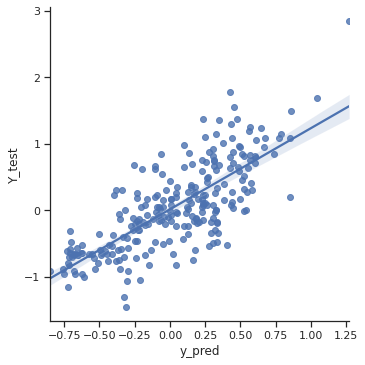

1
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
250
2-fold :  59.199999999999996
3-fold :  75.2
5-fold :  89.60000000000001
gmfe :  2.0590162371217606
mfe :  1.2626301134560234
bias :  0.07557800993407135
rmse  0.41225334427688276
r2  0.5447811435042194
saving model


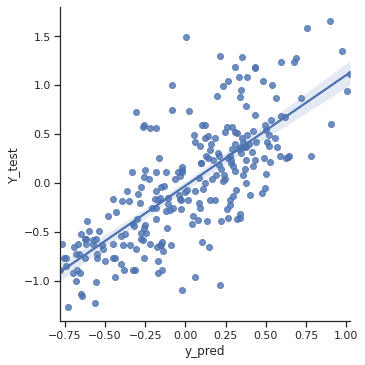

2
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  61.199999999999996
3-fold :  72.39999999999999
5-fold :  85.6
gmfe :  2.225037377254714
mfe :  1.2467232823069436
bias :  0.008338447961142775
rmse  0.48327872707416436
r2  0.46231312601109087


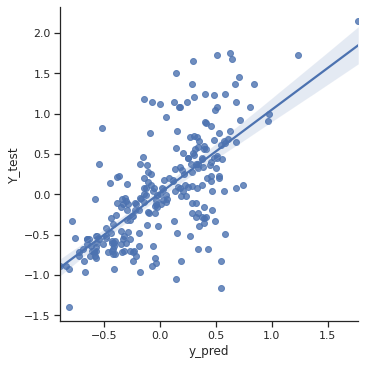

3
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
250
2-fold :  54.400000000000006
3-fold :  75.6
5-fold :  88.0
gmfe :  2.1258373232754213
mfe :  1.2896012692210537
bias :  -0.005849533746560304
rmse  0.43276899660118795
r2  0.5527973354793886


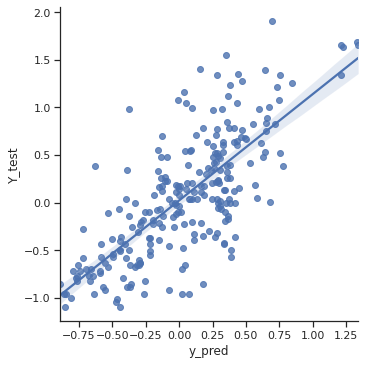

4
(1000, 161)
(249, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
249
2-fold :  57.831325301204814
3-fold :  79.91967871485943
5-fold :  89.95983935742971
gmfe :  2.1283601567296526
mfe :  1.2998759662425672
bias :  0.07396341634908862
rmse  0.42938052487108
r2  0.5221464164515403


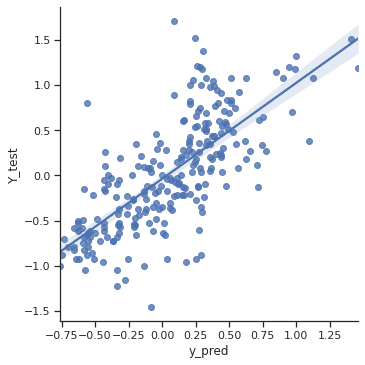

0
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
250
2-fold :  58.8
3-fold :  74.0
5-fold :  88.0
gmfe :  2.1427611679025405
mfe :  1.291668777597693
bias :  0.03260051793569277
rmse  0.4312970249713147
r2  0.490756411426299


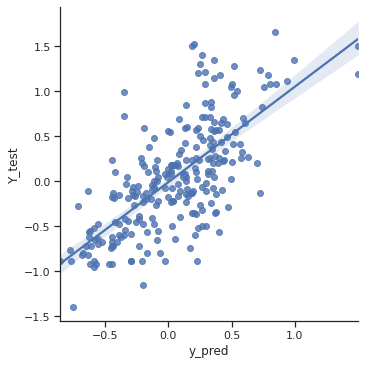

1
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  52.800000000000004
3-fold :  70.0
5-fold :  86.8
gmfe :  2.3221013723305064
mfe :  1.32018565170916
bias :  -0.007534618093317097
rmse  0.4862045708710658
r2  0.48597558467885393


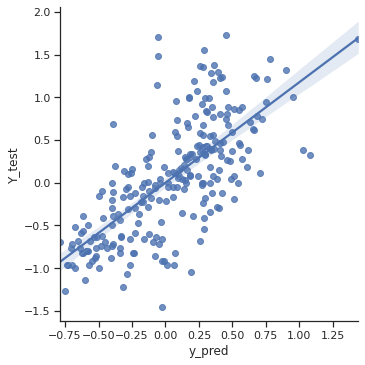

2
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
250
2-fold :  60.0
3-fold :  79.60000000000001
5-fold :  89.2
gmfe :  2.1016724965951035
mfe :  1.2789178267647396
bias :  0.019119562000306095
rmse  0.4402110286431072
r2  0.5065811319229498


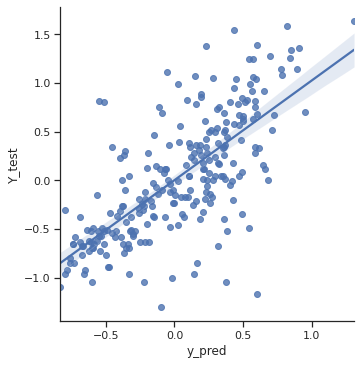

3
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
250
2-fold :  57.599999999999994
3-fold :  78.0
5-fold :  90.8
gmfe :  2.0716441285778275
mfe :  1.279802413391773
bias :  0.024176401825213967
rmse  0.424877569814338
r2  0.5549900785321709


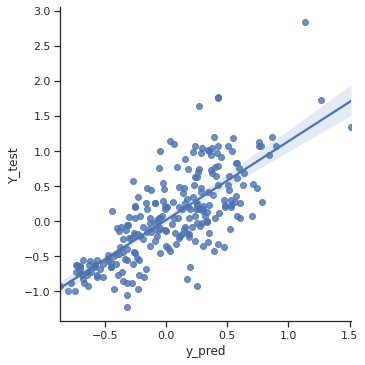

4
(1000, 161)
(249, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  58.23293172690763
3-fold :  75.50200803212851
5-fold :  90.36144578313254
gmfe :  2.069439286123909
mfe :  1.2700496273557214
bias :  0.046504609815884834
rmse  0.425595262158001
r2  0.5695637871800179


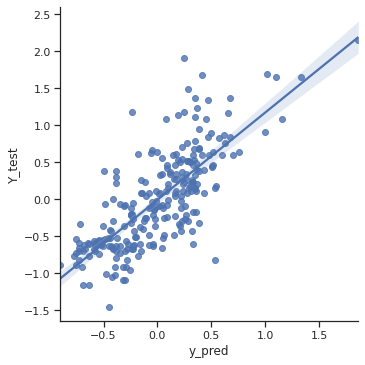

0
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  56.00000000000001
3-fold :  73.2
5-fold :  84.8
gmfe :  2.210433508985216
mfe :  1.297375198125063
bias :  0.022077945336907337
rmse  0.46339330770274917
r2  0.47534519350164917


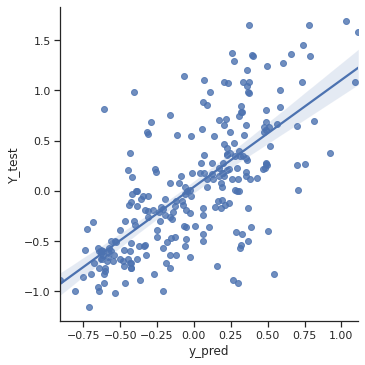

1
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=44)
250
2-fold :  51.6
3-fold :  74.0
5-fold :  87.6
gmfe :  2.2468455974790698
mfe :  1.3290193054101906
bias :  0.015838030418585475
rmse  0.46002114186792237
r2  0.5330053082985813


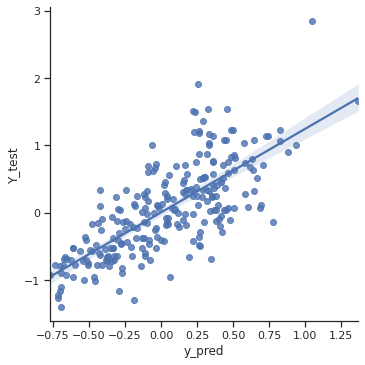

2
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
250
2-fold :  57.99999999999999
3-fold :  73.2
5-fold :  88.0
gmfe :  2.143142535489803
mfe :  1.2616474176717936
bias :  0.035849896720652724
rmse  0.44629220556346993
r2  0.5233042170389586


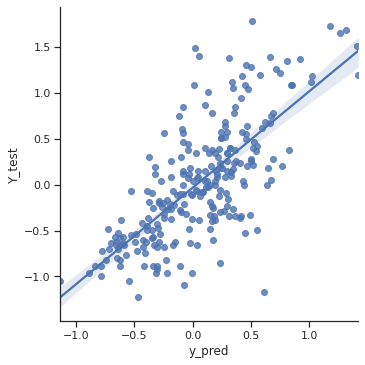

3
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
250
2-fold :  57.199999999999996
3-fold :  78.4
5-fold :  91.60000000000001
gmfe :  2.0638575351371964
mfe :  1.2836828897749468
bias :  0.03316771228384369
rmse  0.42075251904760425
r2  0.5139720721555516


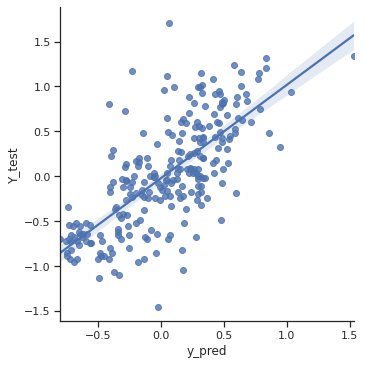

4
(1000, 161)
(249, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  60.24096385542169
3-fold :  81.52610441767068
5-fold :  91.96787148594377
gmfe :  2.001581469737971
mfe :  1.2392022866118764
bias :  0.015487454842306625
rmse  0.4072980997077808
r2  0.5869029384708897
saving model


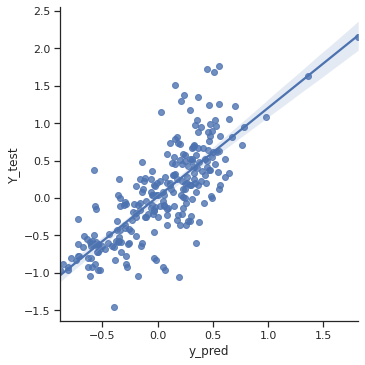

0
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
250
2-fold :  59.199999999999996
3-fold :  74.4
5-fold :  88.8
gmfe :  2.185049482358198
mfe :  1.270345207614489
bias :  0.0024630190345052982
rmse  0.4694351091365602
r2  0.4675086395669925


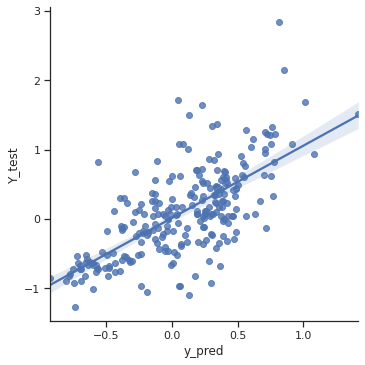

1
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
250
2-fold :  60.0
3-fold :  78.8
5-fold :  88.8
gmfe :  2.0516181581138673
mfe :  1.2668387097064162
bias :  0.012757428442994517
rmse  0.4169055473199904
r2  0.5074554415522545


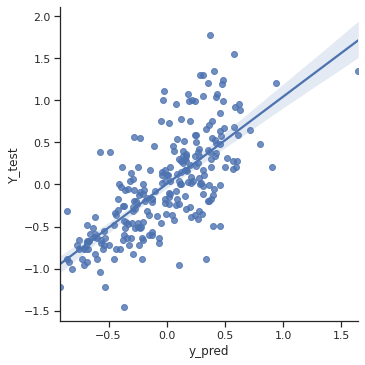

2
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
250
2-fold :  54.800000000000004
3-fold :  69.6
5-fold :  86.0
gmfe :  2.2710412988059745
mfe :  1.286415461426018
bias :  0.005938476313260388
rmse  0.4790389585528918
r2  0.4974983843963243


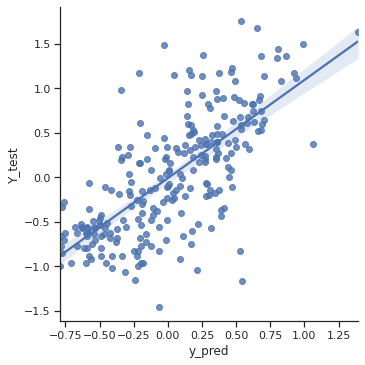

3
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  54.0
3-fold :  76.0
5-fold :  88.8
gmfe :  2.1431077462129693
mfe :  1.3049637311345954
bias :  0.1311817467730974
rmse  0.42664155310860213
r2  0.5381309746544367


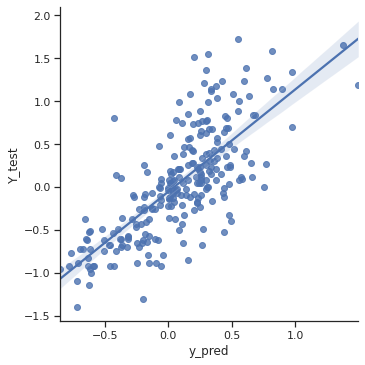

4
(1000, 161)
(249, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
249
2-fold :  61.044176706827315
3-fold :  79.11646586345381
5-fold :  91.96787148594377
gmfe :  1.982200577386852
mfe :  1.2507478173942774
bias :  -0.02525060107284971
rmse  0.39128006256055325
r2  0.6384204423636632
saving model


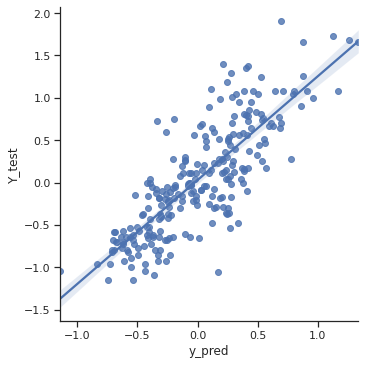

0
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
250
2-fold :  60.8
3-fold :  77.60000000000001
5-fold :  90.0
gmfe :  2.1080733926826576
mfe :  1.2944873230203975
bias :  0.035946567510617006
rmse  0.431947593866365
r2  0.5219982628225449


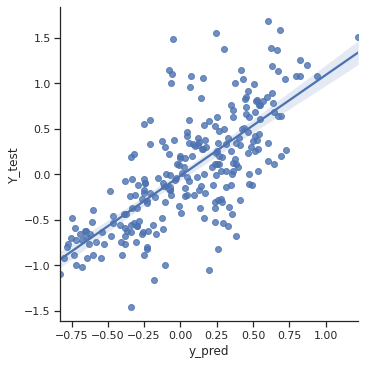

1
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
250
2-fold :  58.4
3-fold :  75.6
5-fold :  90.4
gmfe :  2.1091507093942137
mfe :  1.2623803158384603
bias :  0.06553112497974908
rmse  0.438400513560346
r2  0.5461639936490084


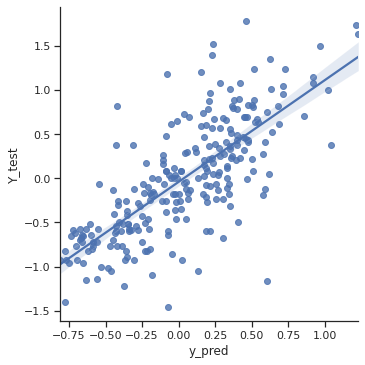

2
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
250
2-fold :  58.4
3-fold :  78.0
5-fold :  86.8
gmfe :  2.1016123732321086
mfe :  1.297821643182921
bias :  0.012125576855614148
rmse  0.4325928002015455
r2  0.5386710050901918


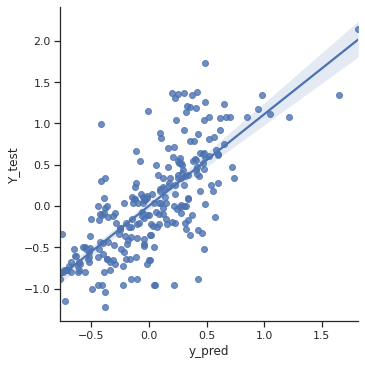

3
(999, 161)
(250, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
250
2-fold :  55.2
3-fold :  75.2
5-fold :  88.8
gmfe :  2.1755461906286775
mfe :  1.3071260828230302
bias :  0.007251027087881556
rmse  0.4390125014505374
r2  0.54560149333663


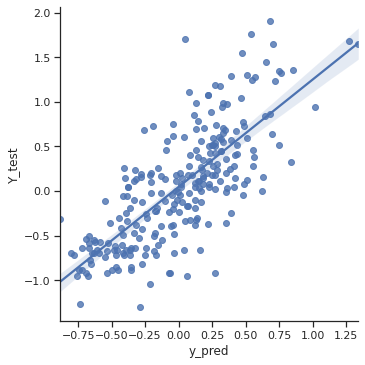

4
(1000, 161)
(249, 161)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
249
2-fold :  56.62650602409639
3-fold :  75.50200803212851
5-fold :  89.5582329317269
gmfe :  2.1190606319815943
mfe :  1.288579075491022
bias :  0.021965706783380307
rmse  0.4347662352076656
r2  0.5285303928724068


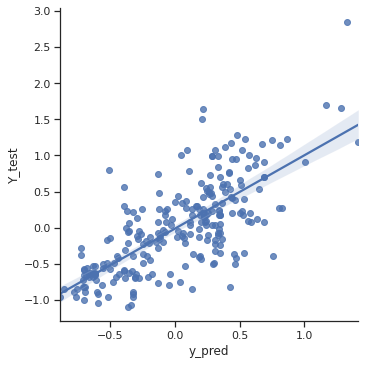

human_CL_mL_min_kg
0
(1024, 161)
(257, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=42)
257
2-fold :  50.583657587548636
3-fold :  71.20622568093385
5-fold :  84.43579766536965
gmfe :  2.528005161661387
mfe :  1.3462144049859837
bias :  -0.23502709913434572
rmse  0.5558316868856756
r2  0.3225662786499697
saving model


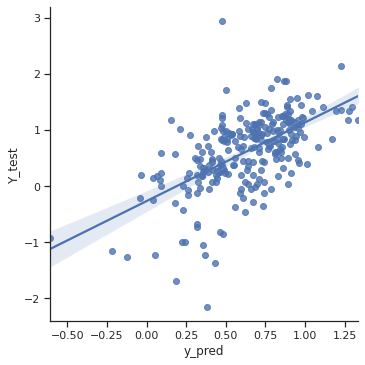

1
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
256
2-fold :  50.0
3-fold :  72.265625
5-fold :  86.71875
gmfe :  2.443956520549282
mfe :  1.3523764411455796
bias :  -0.7217451733883715
rmse  0.5126903132712276
r2  0.35296900100994333
saving model


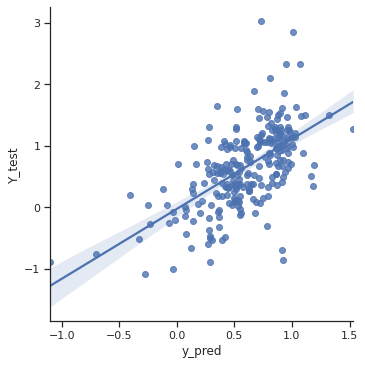

2
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
256
2-fold :  51.171875
3-fold :  71.484375
5-fold :  86.71875
gmfe :  2.4307775117711548
mfe :  1.3407047298720738
bias :  -0.25804464577581154
rmse  0.5229887324806349
r2  0.24221474466608395
saving model


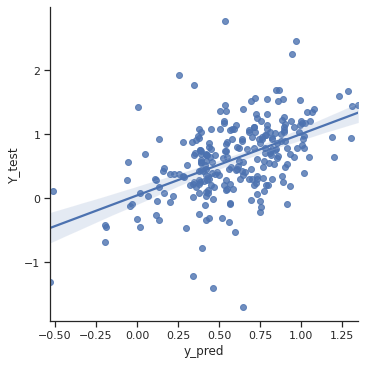

3
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=42)
256
2-fold :  48.828125
3-fold :  70.703125
5-fold :  86.71875
gmfe :  2.4760031868387706
mfe :  1.357922203139757
bias :  -0.5527062297673881
rmse  0.5291318785265388
r2  0.35287160685053587


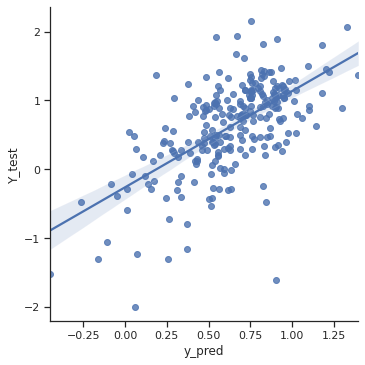

4
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
256
2-fold :  53.515625
3-fold :  69.140625
5-fold :  82.8125
gmfe :  2.55823105779631
mfe :  1.3139280016043617
bias :  0.08114874695977115
rmse  0.578187217157103
r2  0.25318195681503


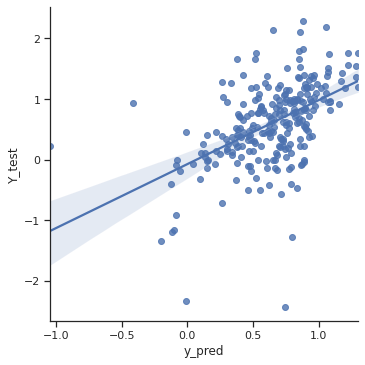

0
(1024, 161)
(257, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
257
2-fold :  50.97276264591439
3-fold :  68.48249027237354
5-fold :  80.93385214007782
gmfe :  2.670598509692195
mfe :  1.3438358242069768
bias :  -0.04989410039639619
rmse  0.6035743209395529
r2  0.2813885234455792


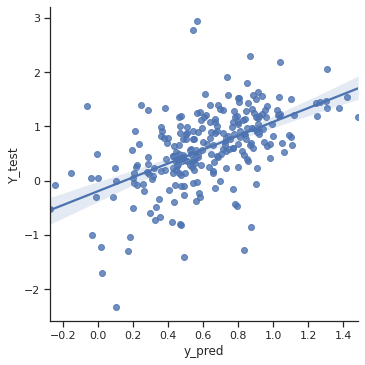

1
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
256
2-fold :  46.09375
3-fold :  66.40625
5-fold :  83.59375
gmfe :  2.7500987703812703
mfe :  1.383996170044736
bias :  -0.5454798495505533
rmse  0.5949647955527491
r2  0.29267771579394897


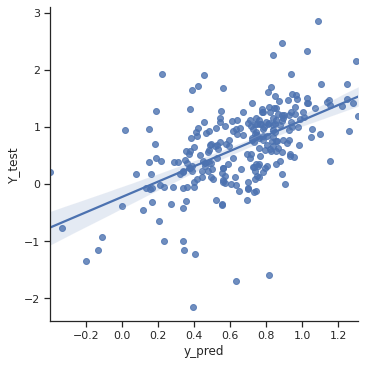

2
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
256
2-fold :  51.171875
3-fold :  69.53125
5-fold :  85.15625
gmfe :  2.443193101327949
mfe :  1.3380584805837432
bias :  -0.320597890306735
rmse  0.5082533801027354
r2  0.28512804136030134


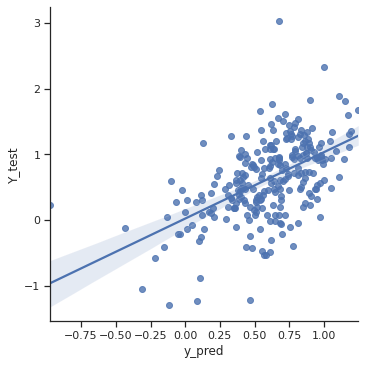

3
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
256
2-fold :  53.125
3-fold :  74.21875
5-fold :  87.109375
gmfe :  2.3058320674765858
mfe :  1.3094035639503914
bias :  -0.30467024253630925
rmse  0.4895512962467116
r2  0.34221138517035665
saving model


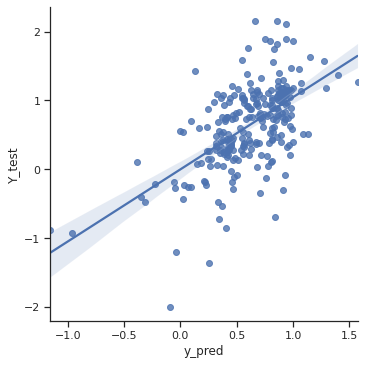

4
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
256
2-fold :  52.734375
3-fold :  71.484375
5-fold :  87.109375
gmfe :  2.3114841917853632
mfe :  1.324628791767008
bias :  -0.1907159818415356
rmse  0.4916361334681909
r2  0.3466911626170971


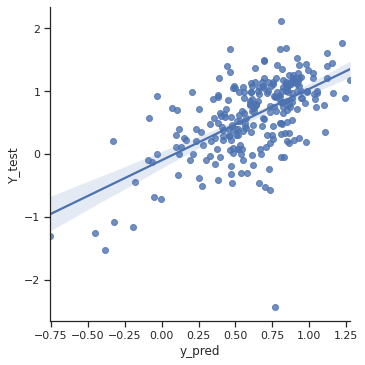

0
(1024, 161)
(257, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
257
2-fold :  52.918287937743195
3-fold :  73.92996108949417
5-fold :  87.15953307392996
gmfe :  2.3351449902967887
mfe :  1.3238311904131104
bias :  -0.4872497129611597
rmse  0.4943282516838427
r2  0.3955219884118424


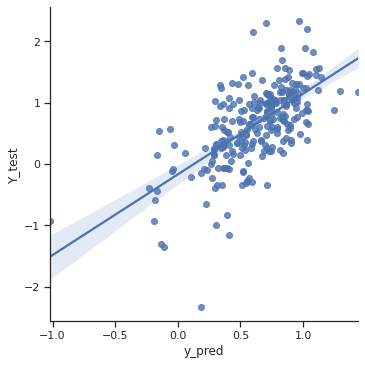

1
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
256
2-fold :  55.859375
3-fold :  73.4375
5-fold :  87.109375
gmfe :  2.359917275881551
mfe :  1.2985320120263044
bias :  -0.41523688277755166
rmse  0.5224241181465734
r2  0.3079408963991803


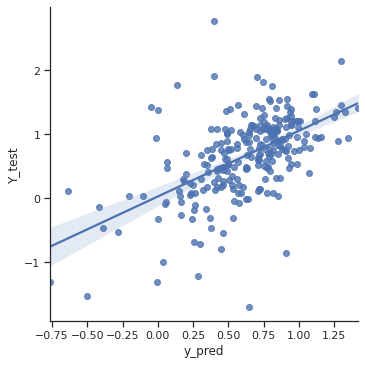

2
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
256
2-fold :  51.171875
3-fold :  67.578125
5-fold :  82.03125
gmfe :  2.5683625941324433
mfe :  1.3359296648303567
bias :  0.04890212233435311
rmse  0.5669755578504704
r2  0.28928845100116274


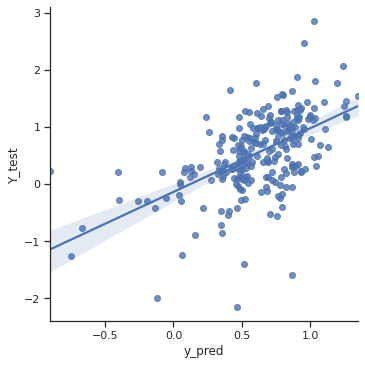

3
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
256
2-fold :  47.65625
3-fold :  66.796875
5-fold :  84.375
gmfe :  2.6672985315704176
mfe :  1.3607562113297378
bias :  -0.022357363222792026
rmse  0.5908666627334108
r2  0.2373308417039316


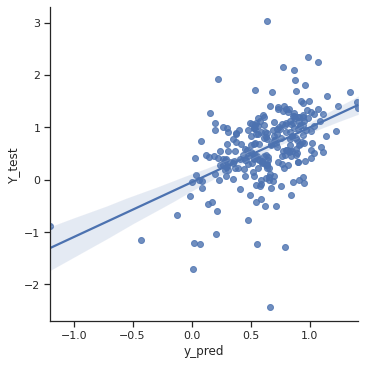

4
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
256
2-fold :  49.21875
3-fold :  67.96875
5-fold :  84.765625
gmfe :  2.441973297757682
mfe :  1.355423207992018
bias :  -0.2899857369608174
rmse  0.5108660682665048
r2  0.32753668498375


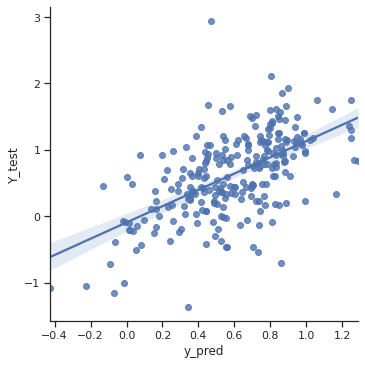

0
(1024, 161)
(257, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
257
2-fold :  47.85992217898833
3-fold :  73.54085603112841
5-fold :  87.93774319066148
gmfe :  2.3045630163769264
mfe :  1.3710252412347006
bias :  -0.511738818614921
rmse  0.4507576658276542
r2  0.38998280200505175
saving model


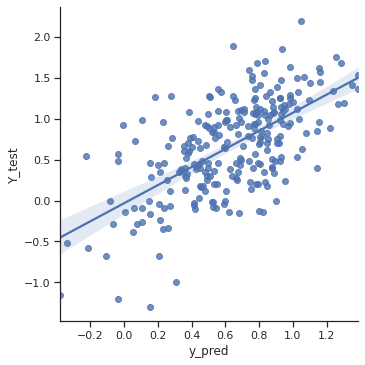

1
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
256
2-fold :  51.953125
3-fold :  69.140625
5-fold :  83.59375
gmfe :  2.4322343791515104
mfe :  1.3415241231430741
bias :  0.2943652529639645
rmse  0.5053432372639746
r2  0.3154418017149221


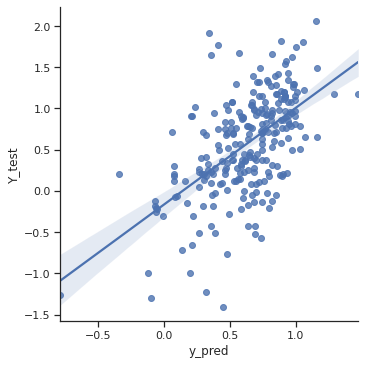

2
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
256
2-fold :  51.953125
3-fold :  69.921875
5-fold :  83.203125
gmfe :  2.5940670560514376
mfe :  1.3265762601119038
bias :  -0.9647167313516243
rmse  0.581405121722409
r2  0.23981797696347107


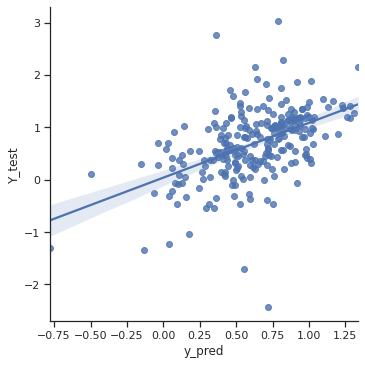

3
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
256
2-fold :  56.25
3-fold :  74.21875
5-fold :  86.328125
gmfe :  2.38250016416814
mfe :  1.2722511820676814
bias :  -0.0929431544314685
rmse  0.5347121098798695
r2  0.3021681655953813


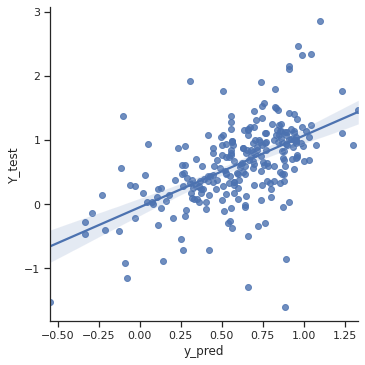

4
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
256
2-fold :  50.390625
3-fold :  66.40625
5-fold :  83.59375
gmfe :  2.690107963753388
mfe :  1.3465026944150824
bias :  0.10155997361201208
rmse  0.6107344203322875
r2  0.2995728465216396


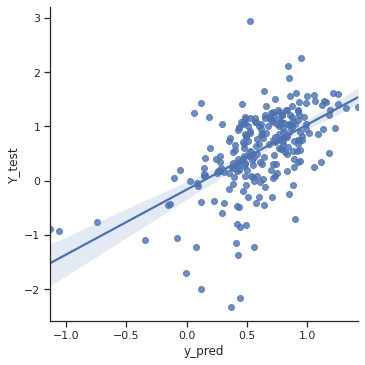

0
(1024, 161)
(257, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
257
2-fold :  51.36186770428015
3-fold :  72.76264591439688
5-fold :  85.60311284046692
gmfe :  2.4268102697197866
mfe :  1.3271656214512602
bias :  -0.6985980687069233
rmse  0.5426098687957278
r2  0.2688817816368345


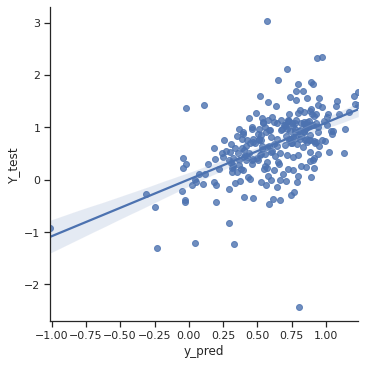

1
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
256
2-fold :  49.21875
3-fold :  64.84375
5-fold :  81.25
gmfe :  2.742088089761123
mfe :  1.3594066690642097
bias :  -0.0837484817239953
rmse  0.5993229216992796
r2  0.2997058792588154


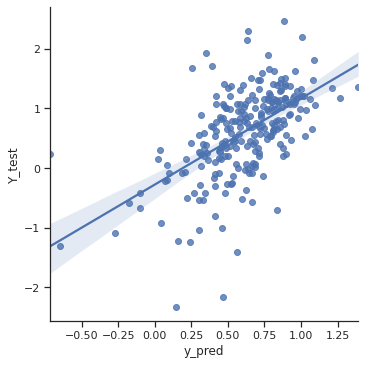

2
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
256
2-fold :  50.78125
3-fold :  69.140625
5-fold :  83.984375
gmfe :  2.532219777423546
mfe :  1.3439140743406748
bias :  0.20997154747919322
rmse  0.5746032149378846
r2  0.24852395101018532


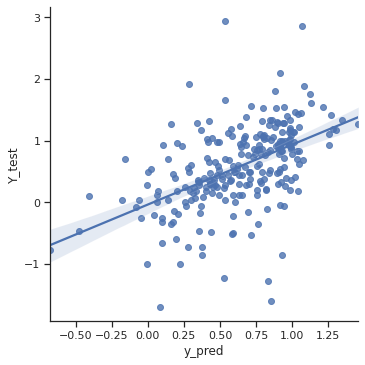

3
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
256
2-fold :  48.046875
3-fold :  70.703125
5-fold :  87.109375
gmfe :  2.4558985689442685
mfe :  1.372327551295505
bias :  -0.12936145982241265
rmse  0.5245906652681511
r2  0.340476438650985


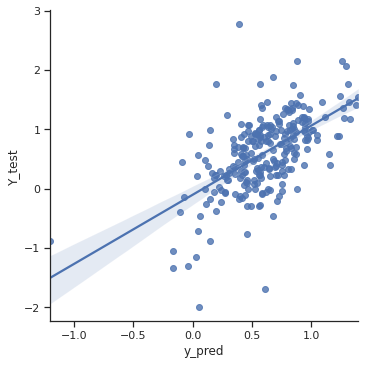

4
(1025, 161)
(256, 161)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
256
2-fold :  55.859375
3-fold :  75.0
5-fold :  89.453125
gmfe :  2.182327008678977
mfe :  1.298098751780776
bias :  -0.4028288261685966
rmse  0.4414779744036816
r2  0.4054615467493583
saving model


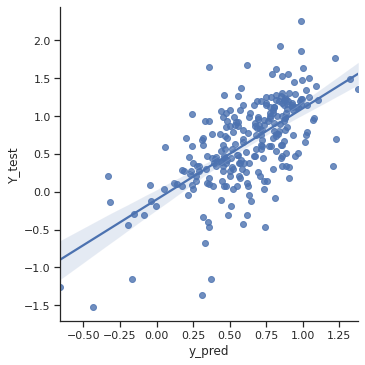

human_fup
0
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=42)
176
2-fold :  48.86363636363637
3-fold :  64.20454545454545
5-fold :  76.13636363636364
gmfe :  3.171223796441461
mfe :  1.3685139043012737
bias :  0.056380843918436195
rmse  0.22355330819147765
r2  0.5949807214763057
saving model


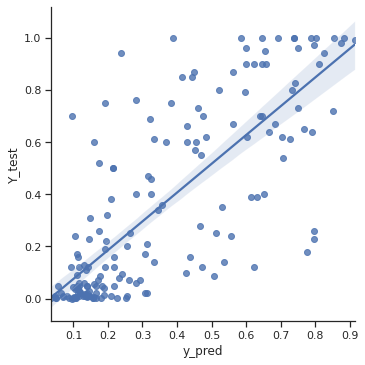

1
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=42)
176
2-fold :  59.09090909090909
3-fold :  71.5909090909091
5-fold :  78.4090909090909
gmfe :  2.662805605677169
mfe :  1.2667593734420388
bias :  0.04814569442121379
rmse  0.1956387016785281
r2  0.6222607112016484
saving model


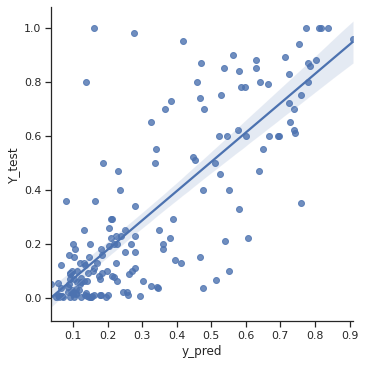

2
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
176
2-fold :  61.93181818181818
3-fold :  69.88636363636364
5-fold :  82.38636363636364
gmfe :  2.5786058772334925
mfe :  1.2681910933012828
bias :  0.0213786170087103
rmse  0.23142775146441752
r2  0.5542327525207071
saving model


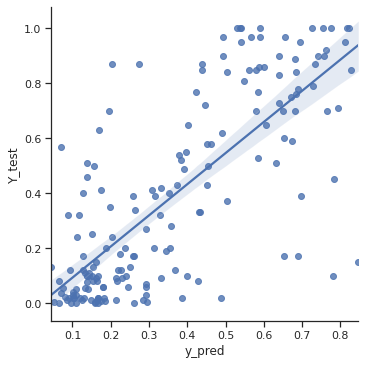

3
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
176
2-fold :  53.40909090909091
3-fold :  64.77272727272727
5-fold :  76.70454545454545
gmfe :  2.785354379084014
mfe :  1.2906706619344204
bias :  0.056363509336024416
rmse  0.21760283311607428
r2  0.6051662637143471


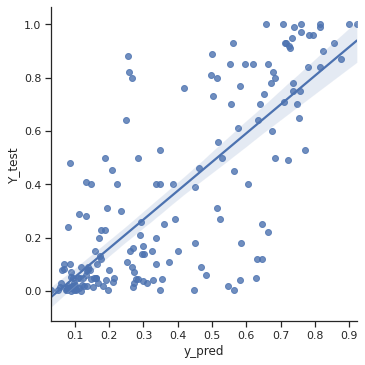

4
(704, 161)
(175, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
175
2-fold :  53.714285714285715
3-fold :  65.71428571428571
5-fold :  74.85714285714286
gmfe :  2.7941621167104813
mfe :  1.295104511768039
bias :  0.05253050965232953
rmse  0.20457545871908497
r2  0.6290432227674101


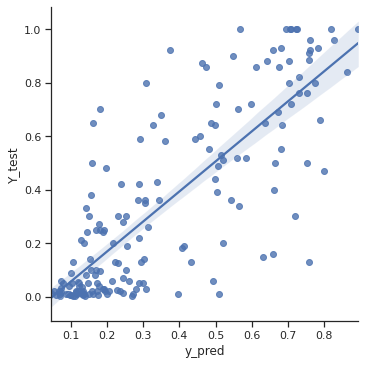

0
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  53.97727272727273
3-fold :  65.9090909090909
5-fold :  79.54545454545455
gmfe :  2.7393607461624128
mfe :  1.303370333839205
bias :  0.04538387042414089
rmse  0.2185403140037618
r2  0.5839584123876993


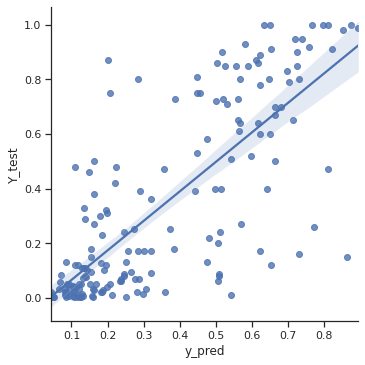

1
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  58.52272727272727
3-fold :  67.04545454545455
5-fold :  76.13636363636364
gmfe :  2.72005950932869
mfe :  1.2038646163442832
bias :  0.053551540455208324
rmse  0.19732035736465472
r2  0.6226503276871393


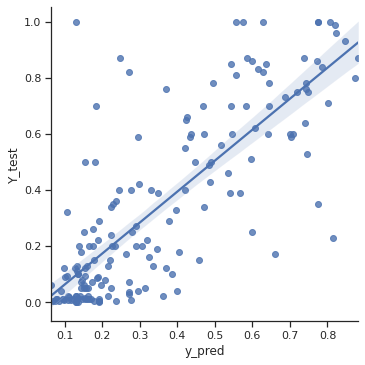

2
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
176
2-fold :  54.54545454545454
3-fold :  67.61363636363636
5-fold :  75.56818181818183
gmfe :  3.062013529594164
mfe :  1.2951400835147366
bias :  0.04481872405900714
rmse  0.2223163760673412
r2  0.6375743699501843


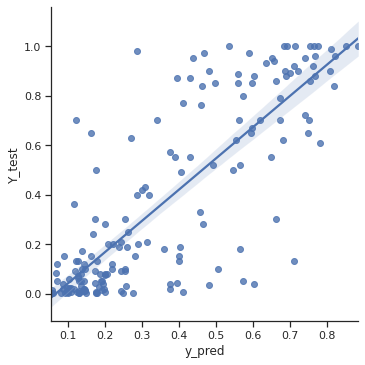

3
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  52.84090909090909
3-fold :  67.04545454545455
5-fold :  76.13636363636364
gmfe :  2.9281470917173547
mfe :  1.3216920592489907
bias :  0.013235059608760563
rmse  0.24162723013524753
r2  0.5397392096344764


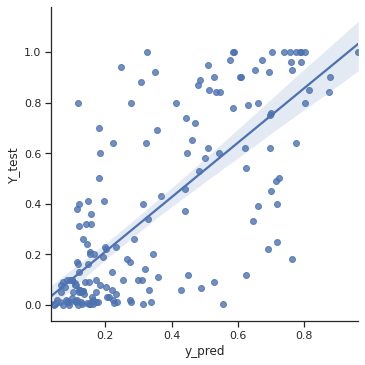

4
(704, 161)
(175, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=43)
175
2-fold :  53.714285714285715
3-fold :  72.57142857142857
5-fold :  81.14285714285714
gmfe :  2.4172165489545754
mfe :  1.2851657613090064
bias :  0.036026458397695464
rmse  0.18385092483958324
r2  0.6547179375632538
saving model


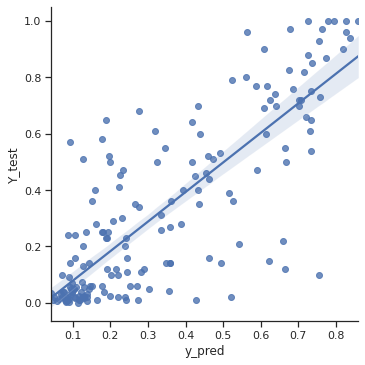

0
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
176
2-fold :  56.25
3-fold :  68.18181818181817
5-fold :  80.68181818181817
gmfe :  2.49493021921326
mfe :  1.2349642635622873
bias :  0.0447475157111231
rmse  0.20755482629828814
r2  0.6466816063489651


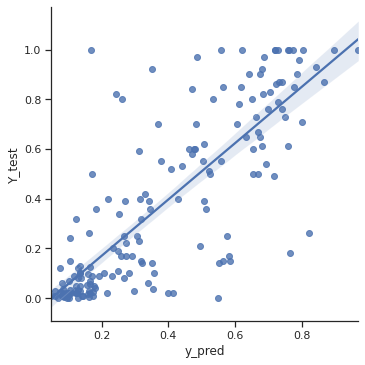

1
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
176
2-fold :  53.40909090909091
3-fold :  67.04545454545455
5-fold :  78.4090909090909
gmfe :  2.809462535939491
mfe :  1.3062330675996743
bias :  0.04654593762949369
rmse  0.21248925566689936
r2  0.5868155527661625


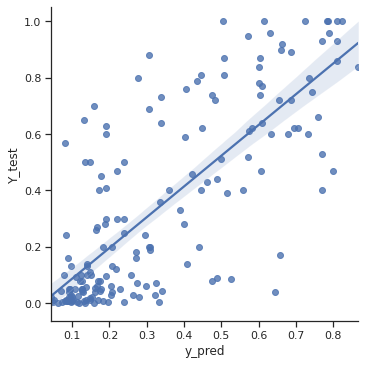

2
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
176
2-fold :  57.38636363636363
3-fold :  70.45454545454545
5-fold :  77.27272727272727
gmfe :  2.8929731349432415
mfe :  1.2511565497408754
bias :  0.044928399419860675
rmse  0.20781552001579168
r2  0.624174053885395


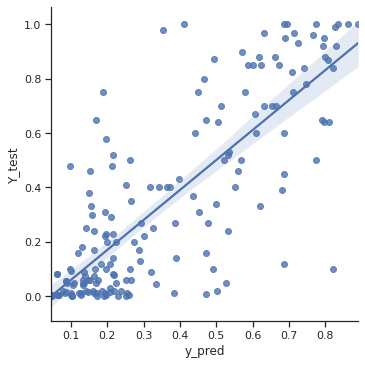

3
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
176
2-fold :  53.40909090909091
3-fold :  69.31818181818183
5-fold :  77.8409090909091
gmfe :  2.8902340495864114
mfe :  1.3114709115581777
bias :  0.03732911648462746
rmse  0.21707367470085936
r2  0.620224791541028


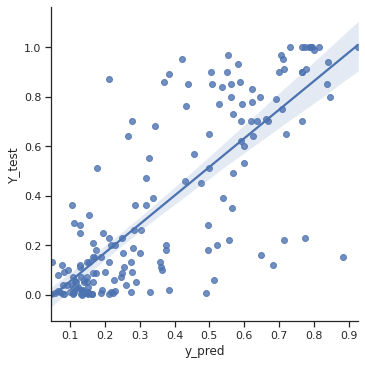

4
(704, 161)
(175, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
175
2-fold :  53.714285714285715
3-fold :  63.42857142857142
5-fold :  76.0
gmfe :  2.7176957019404906
mfe :  1.2933645678573362
bias :  0.05375299844965058
rmse  0.2016187188630067
r2  0.6268250961915811


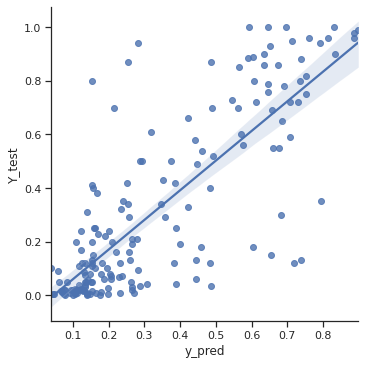

0
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
176
2-fold :  48.29545454545455
3-fold :  62.5
5-fold :  76.70454545454545
gmfe :  3.059886316533894
mfe :  1.3728090344097124
bias :  0.06969235826139174
rmse  0.20578086398111411
r2  0.5474330438378592


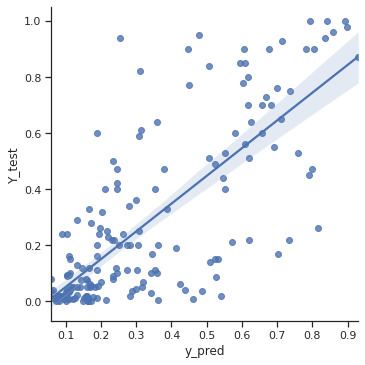

1
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
176
2-fold :  52.27272727272727
3-fold :  68.18181818181817
5-fold :  76.70454545454545
gmfe :  2.6275746279175802
mfe :  1.2851653000838095
bias :  0.035188132916386776
rmse  0.23163359414303838
r2  0.5363493521938488


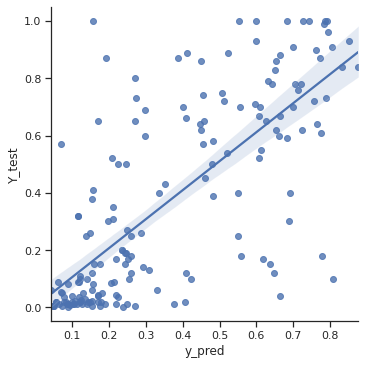

2
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
176
2-fold :  60.22727272727273
3-fold :  71.02272727272727
5-fold :  78.97727272727273
gmfe :  2.6679616144786085
mfe :  1.2551425406389736
bias :  0.011218115059648232
rmse  0.20434929776635036
r2  0.6697790121700903


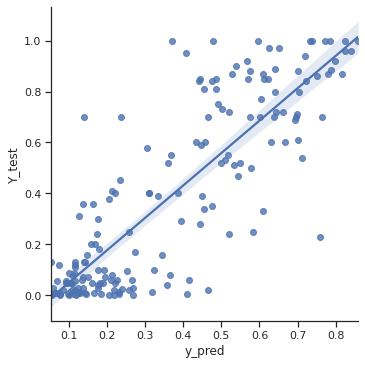

3
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
176
2-fold :  59.65909090909091
3-fold :  67.04545454545455
5-fold :  78.97727272727273
gmfe :  2.6749166143076883
mfe :  1.2478417053112714
bias :  0.044430015828693846
rmse  0.2080155998862445
r2  0.61951413709763


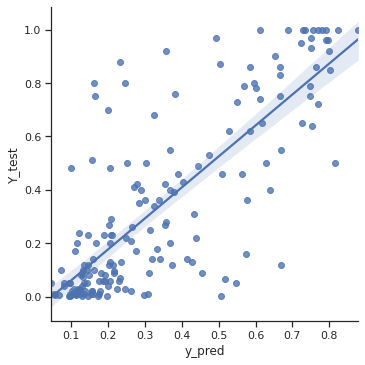

4
(704, 161)
(175, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
175
2-fold :  58.285714285714285
3-fold :  71.42857142857143
5-fold :  78.28571428571428
gmfe :  2.807567958224168
mfe :  1.2392665859800098
bias :  0.04809147301330413
rmse  0.20918900362874274
r2  0.648215164029237


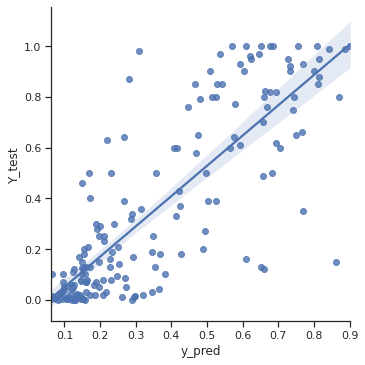

0
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
176
2-fold :  51.70454545454546
3-fold :  64.20454545454545
5-fold :  73.86363636363636
gmfe :  3.0930673985580355
mfe :  1.3088806855911617
bias :  0.06243328255946802
rmse  0.2323842578096877
r2  0.5585688139297127


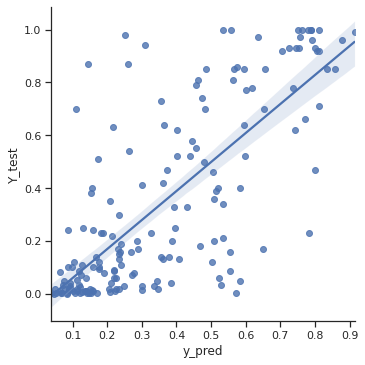

1
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
176
2-fold :  61.36363636363637
3-fold :  72.72727272727273
5-fold :  82.38636363636364
gmfe :  2.593452935395766
mfe :  1.2518738755953631
bias :  0.026130919246269906
rmse  0.19931350828923564
r2  0.63944937951084


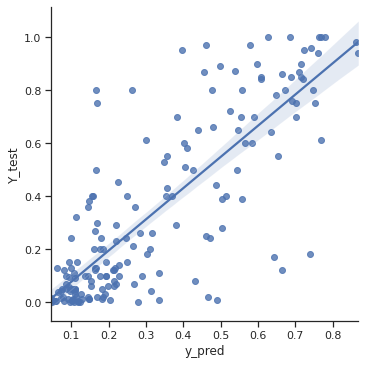

2
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
176
2-fold :  52.27272727272727
3-fold :  65.3409090909091
5-fold :  75.56818181818183
gmfe :  2.853433817821265
mfe :  1.3056251951233175
bias :  0.05495265478305926
rmse  0.22106950170160453
r2  0.5921783527328197


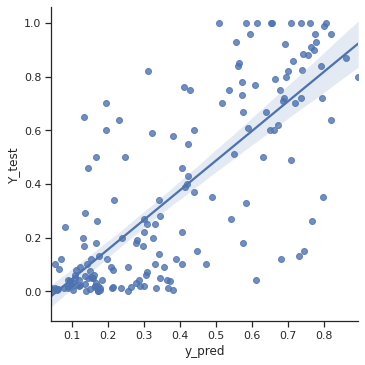

3
(703, 161)
(176, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
176
2-fold :  62.5
3-fold :  74.43181818181817
5-fold :  81.25
gmfe :  2.512933592110037
mfe :  1.178346245027243
bias :  0.021608879435239616
rmse  0.17431176653516123
r2  0.7186272418726167


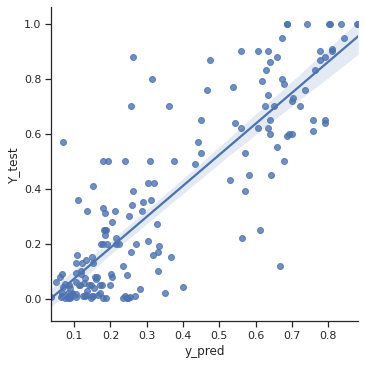

4
(704, 161)
(175, 161)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
175
2-fold :  52.0
3-fold :  65.71428571428571
5-fold :  76.0
gmfe :  2.788059775303269
mfe :  1.3298563332960551
bias :  0.04703571133426107
rmse  0.22127251410460755
r2  0.5925286078159447


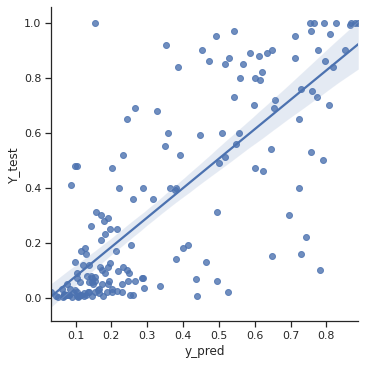

human_mrt
0
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
249
2-fold :  47.791164658634536
3-fold :  69.47791164658635
5-fold :  82.32931726907631
gmfe :  2.5048220344133325
mfe :  1.3662575973271343
bias :  -0.009751326949879235
rmse  0.523914834638317
r2  0.2866123941018933
saving model


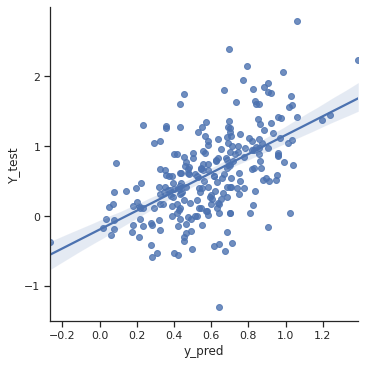

1
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
249
2-fold :  52.208835341365464
3-fold :  71.4859437751004
5-fold :  87.14859437751004
gmfe :  2.371438191144764
mfe :  1.3371821834003021
bias :  -0.1862716848797885
rmse  0.517092878010075
r2  0.2635624333024701
saving model


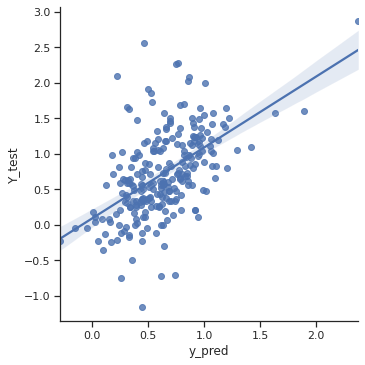

2
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
249
2-fold :  53.01204819277109
3-fold :  70.28112449799197
5-fold :  82.73092369477911
gmfe :  2.5412479823369516
mfe :  1.3187235809449054
bias :  -0.09881817467385279
rmse  0.5505984487163349
r2  0.3078510643481681


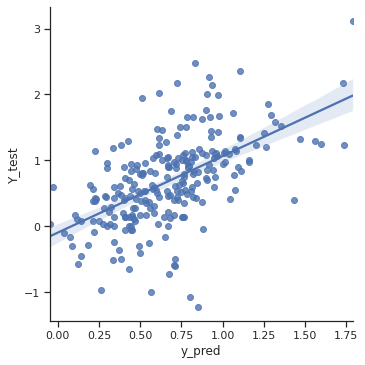

3
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
248
2-fold :  49.596774193548384
3-fold :  68.54838709677419
5-fold :  83.06451612903226
gmfe :  2.6549979912011388
mfe :  1.3575581238857073
bias :  0.15422758635747957
rmse  0.5909619782149719
r2  0.272060644664485


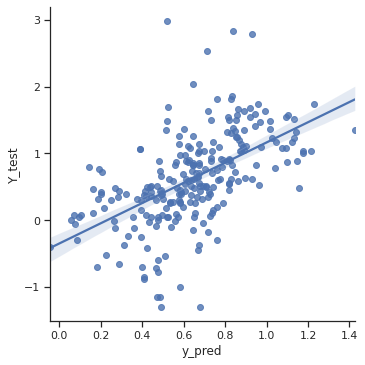

4
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
248
2-fold :  46.37096774193548
3-fold :  68.14516129032258
5-fold :  82.66129032258065
gmfe :  2.575412883853411
mfe :  1.3713248392984623
bias :  0.4852789758850604
rmse  0.548048599791639
r2  0.2097297995145141


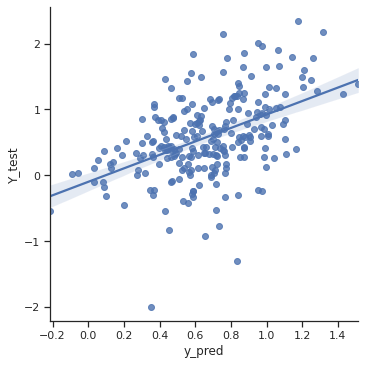

0
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
249
2-fold :  47.791164658634536
3-fold :  69.07630522088354
5-fold :  86.34538152610442
gmfe :  2.535657855412256
mfe :  1.3802235874004722
bias :  -0.21273090588193622
rmse  0.5515457778355608
r2  0.2614218779149343


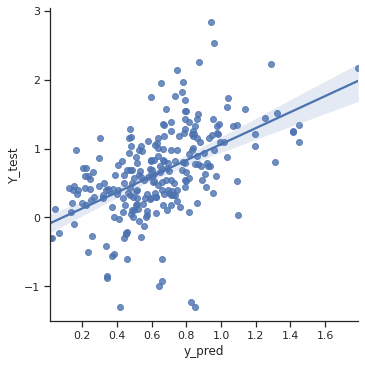

1
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  47.389558232931726
3-fold :  65.86345381526104
5-fold :  79.91967871485943
gmfe :  2.7222766050063774
mfe :  1.3715946623283493
bias :  0.060586508028696695
rmse  0.5909994873712289
r2  0.27578250691774897


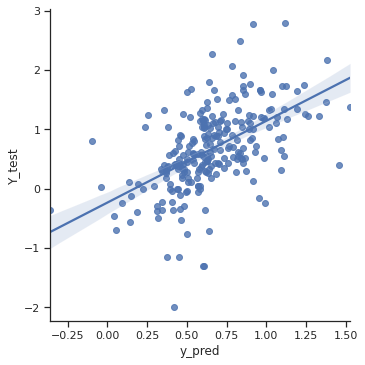

2
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  46.98795180722892
3-fold :  65.86345381526104
5-fold :  85.14056224899599
gmfe :  2.491749941855648
mfe :  1.3739578571388331
bias :  -0.03304693192229058
rmse  0.5173118968646255
r2  0.2864066576172196


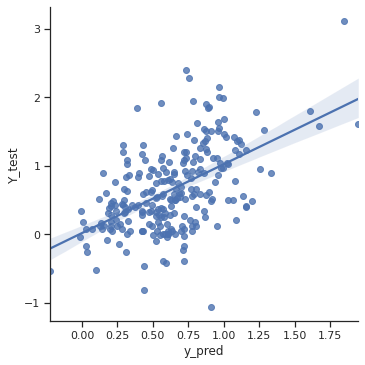

3
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
248
2-fold :  51.61290322580645
3-fold :  70.96774193548387
5-fold :  81.04838709677419
gmfe :  2.5566031734676167
mfe :  1.3331304505790205
bias :  -0.09415171388181154
rmse  0.562315143759004
r2  0.2718058993840947


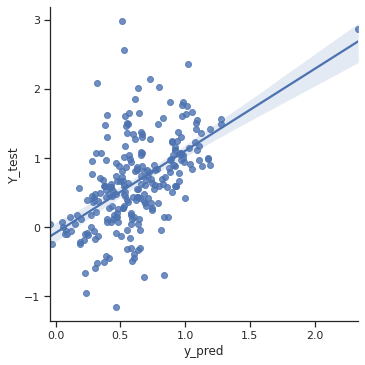

4
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
248
2-fold :  54.83870967741935
3-fold :  74.19354838709677
5-fold :  86.29032258064517
gmfe :  2.2815678054802837
mfe :  1.315449803338287
bias :  0.13648479786350204
rmse  0.4776540884375206
r2  0.3521132472135675
saving model


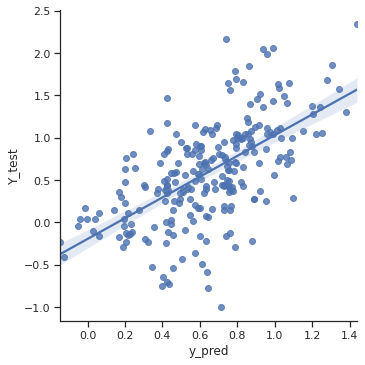

0
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  48.99598393574297
3-fold :  69.07630522088354
5-fold :  85.14056224899599
gmfe :  2.451400422994906
mfe :  1.3793205855099955
bias :  0.10475814384115845
rmse  0.5119287013185366
r2  0.2553904498306844


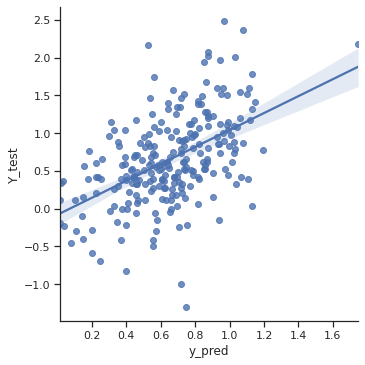

1
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  49.79919678714859
3-fold :  68.27309236947792
5-fold :  83.13253012048193
gmfe :  2.635950378038052
mfe :  1.3548540293511564
bias :  0.24586600467073505
rmse  0.5822939709920391
r2  0.2925759704559754


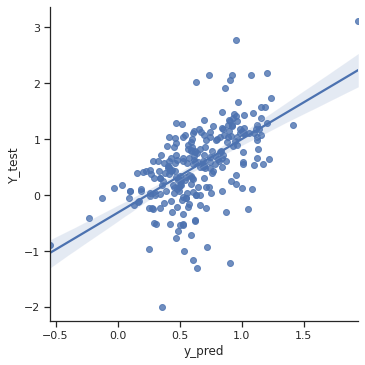

2
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
249
2-fold :  50.602409638554214
3-fold :  70.68273092369478
5-fold :  85.54216867469879
gmfe :  2.432746988017375
mfe :  1.3357465840504528
bias :  -0.043840937249049805
rmse  0.5241093630271219
r2  0.29091171471488075


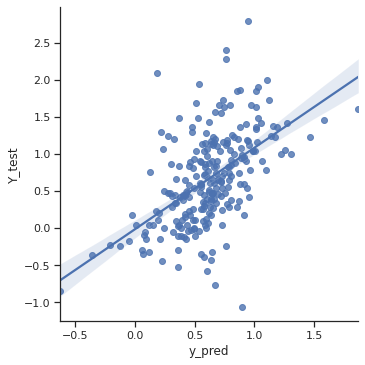

3
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=44)
248
2-fold :  51.20967741935484
3-fold :  68.95161290322581
5-fold :  79.43548387096774
gmfe :  2.5586194682413748
mfe :  1.3355770651810959
bias :  0.1903919541095347
rmse  0.5506059254756106
r2  0.22581121350520272


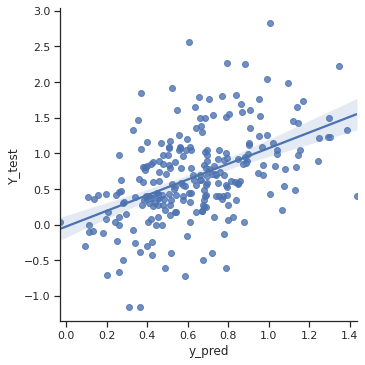

4
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
248
2-fold :  47.17741935483871
3-fold :  68.95161290322581
5-fold :  85.48387096774194
gmfe :  2.4674260834929544
mfe :  1.3803095468871234
bias :  -0.07114875341650317
rmse  0.5313898633173268
r2  0.3506980571014544


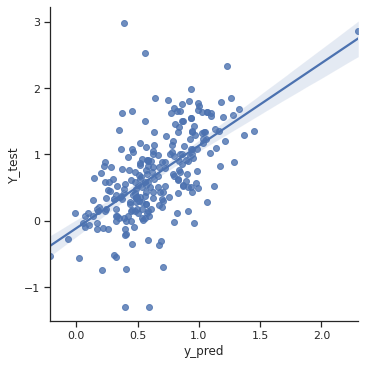

0
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
249
2-fold :  49.79919678714859
3-fold :  67.46987951807229
5-fold :  83.13253012048193
gmfe :  2.5403295160031596
mfe :  1.3620543818999338
bias :  -0.4508852790642923
rmse  0.5506912447219814
r2  0.24483040142644852


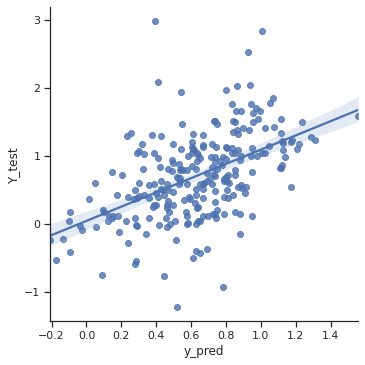

1
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
249
2-fold :  46.1847389558233
3-fold :  64.65863453815261
5-fold :  81.12449799196787
gmfe :  2.733708911912721
mfe :  1.4052167786700753
bias :  0.21818831211984513
rmse  0.5939740874510004
r2  0.2777827274433946


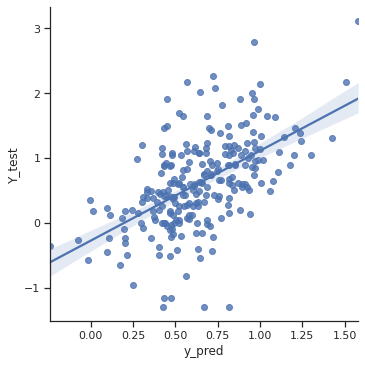

2
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
249
2-fold :  53.41365461847389
3-fold :  70.68273092369478
5-fold :  85.14056224899599
gmfe :  2.4423530243878604
mfe :  1.3300554392703225
bias :  -0.15242126985208482
rmse  0.5312084067190187
r2  0.29988336523751935


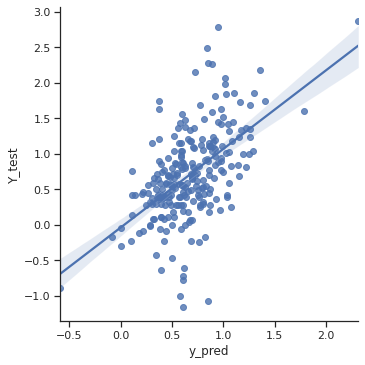

3
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
248
2-fold :  48.79032258064516
3-fold :  71.37096774193549
5-fold :  84.67741935483872
gmfe :  2.4295424026638663
mfe :  1.3733912643190995
bias :  0.06260484582582682
rmse  0.5096235796697285
r2  0.2852029387883699


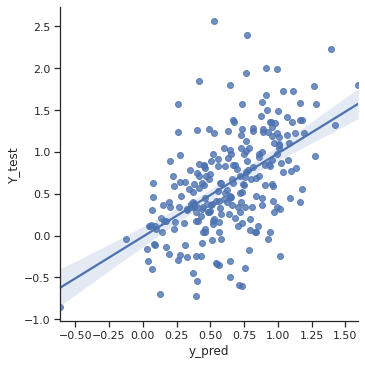

4
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
248
2-fold :  46.774193548387096
3-fold :  69.35483870967742
5-fold :  85.88709677419355
gmfe :  2.474713900736075
mfe :  1.3854548634804085
bias :  0.521948218680907
rmse  0.5261280353660069
r2  0.28978923743151597


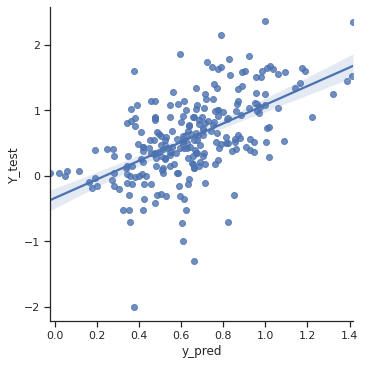

0
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=46)
249
2-fold :  44.57831325301205
3-fold :  69.07630522088354
5-fold :  80.32128514056225
gmfe :  2.6574689756389533
mfe :  1.384147997542079
bias :  -0.28091376109325017
rmse  0.5635535718910335
r2  0.29648395175000153


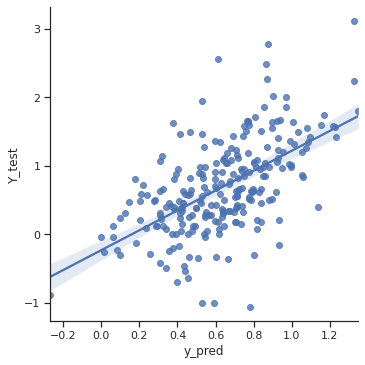

1
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
249
2-fold :  51.40562248995983
3-fold :  69.47791164658635
5-fold :  85.94377510040161
gmfe :  2.4135551279610343
mfe :  1.3435002829307119
bias :  0.10930417728535735
rmse  0.5110815163574907
r2  0.32796793435305616


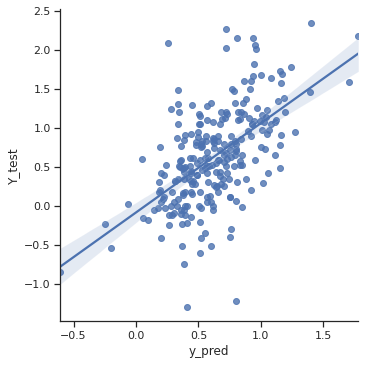

2
(994, 161)
(249, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
249
2-fold :  52.610441767068274
3-fold :  73.89558232931726
5-fold :  86.74698795180723
gmfe :  2.302513830493987
mfe :  1.3248336266349685
bias :  0.078176866574168
rmse  0.4989259022608889
r2  0.32895426247679693


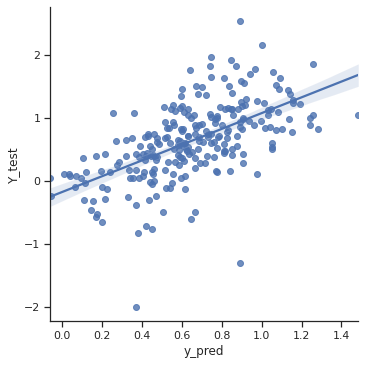

3
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
248
2-fold :  46.774193548387096
3-fold :  64.11290322580645
5-fold :  79.03225806451613
gmfe :  2.7855986701860265
mfe :  1.394597753318698
bias :  -0.025318257159653856
rmse  0.611833999555567
r2  0.20369840372423098


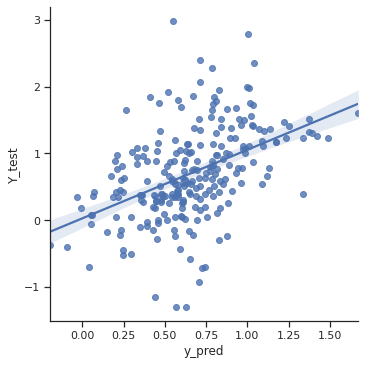

4
(995, 161)
(248, 161)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
248
2-fold :  47.983870967741936
3-fold :  70.96774193548387
5-fold :  86.29032258064517
gmfe :  2.4445265171502624
mfe :  1.3741588783074914
bias :  0.3623162761967147
rmse  0.5092748403122431
r2  0.29524771776684466


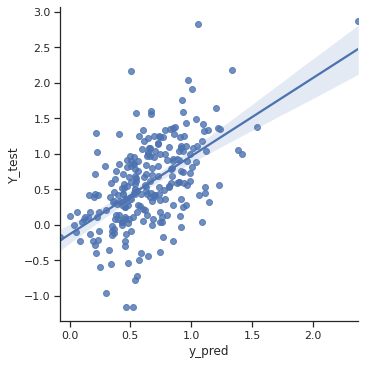

human_thalf
0
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  46.24505928853755
3-fold :  68.37944664031622
5-fold :  84.98023715415019
gmfe :  2.5441419079037586
mfe :  1.3787576784777484
bias :  0.07141289308540144
rmse  0.5258610180823036
r2  0.2980480138047298
saving model


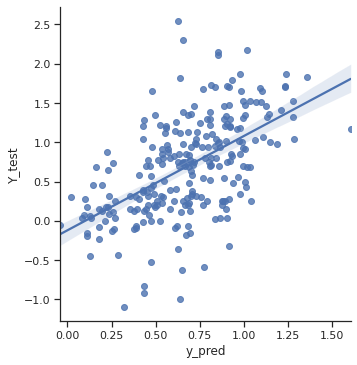

1
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
253
2-fold :  51.38339920948617
3-fold :  67.19367588932806
5-fold :  86.16600790513834
gmfe :  2.4540765715657544
mfe :  1.3414589488655988
bias :  0.1203058947635216
rmse  0.5157650855876749
r2  0.3117031137130176
saving model


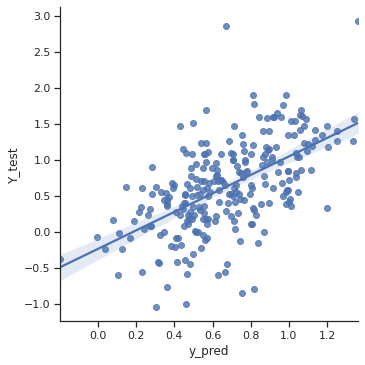

2
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  48.616600790513836
3-fold :  74.30830039525692
5-fold :  87.74703557312253
gmfe :  2.327375472496637
mfe :  1.3686651333136137
bias :  0.16901455935822218
rmse  0.48251975230292354
r2  0.3159260054656149
saving model


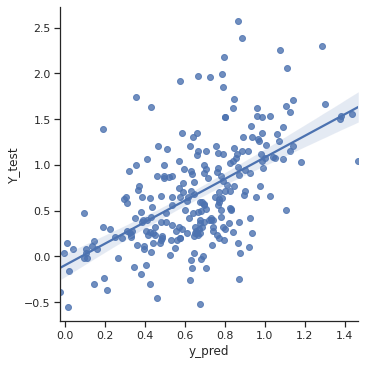

3
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  47.82608695652174
3-fold :  69.96047430830039
5-fold :  81.81818181818183
gmfe :  2.67834128207049
mfe :  1.3741766145912417
bias :  0.15902486097901658
rmse  0.5898319231881044
r2  0.2886309622150385


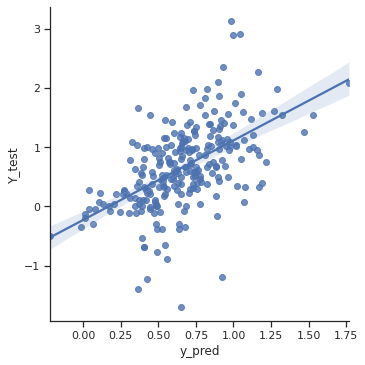

4
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  55.33596837944664
3-fold :  75.8893280632411
5-fold :  89.72332015810277
gmfe :  2.1982038168992726
mfe :  1.2978143430396312
bias :  0.019247996957845404
rmse  0.4593702678086021
r2  0.35613717631282227
saving model


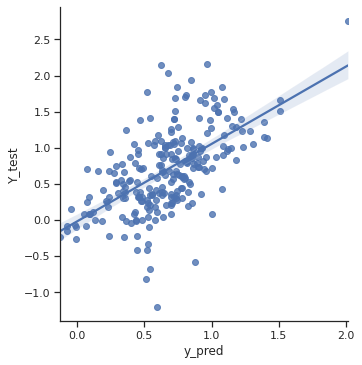

0
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  49.40711462450593
3-fold :  70.7509881422925
5-fold :  90.51383399209486
gmfe :  2.277079381975094
mfe :  1.3600540775012433
bias :  -0.10030406004863379
rmse  0.45906264578348394
r2  0.33753808383200545


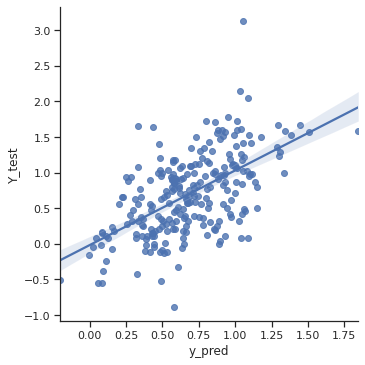

1
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
253
2-fold :  50.988142292490124
3-fold :  71.54150197628458
5-fold :  81.42292490118577
gmfe :  2.58873027753438
mfe :  1.3433392437229084
bias :  0.5212046054493324
rmse  0.5689031575797098
r2  0.2724138234122472


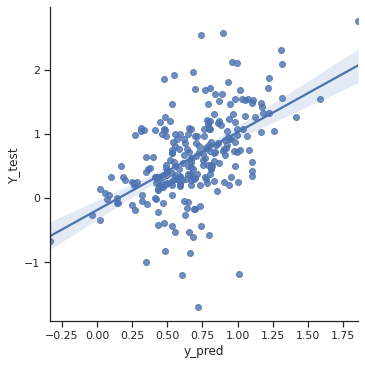

2
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  46.6403162055336
3-fold :  71.93675889328063
5-fold :  84.98023715415019
gmfe :  2.483259097087173
mfe :  1.3693044389536202
bias :  -0.14708139283103439
rmse  0.5200258909820401
r2  0.2674464622587812


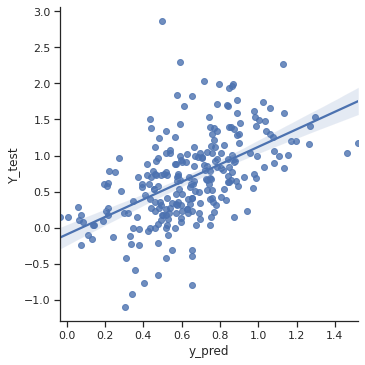

3
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
253
2-fold :  49.01185770750988
3-fold :  69.56521739130434
5-fold :  84.58498023715416
gmfe :  2.4592067106161934
mfe :  1.367265447183572
bias :  -0.02432321734482512
rmse  0.5124916064702563
r2  0.3146860374919741


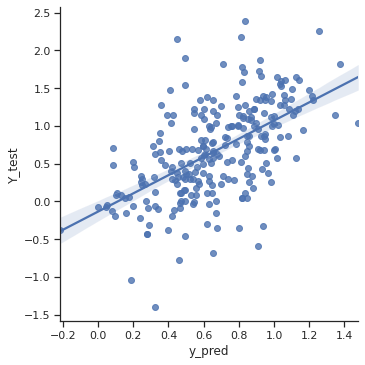

4
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  51.38339920948617
3-fold :  71.93675889328063
5-fold :  86.16600790513834
gmfe :  2.4023051280550036
mfe :  1.3407903422672824
bias :  0.13436801796709807
rmse  0.5184502644561105
r2  0.36529752780184666


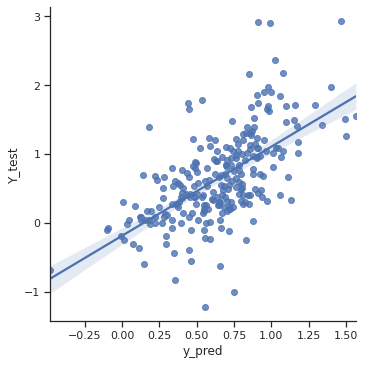

0
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
253
2-fold :  50.59288537549407
3-fold :  75.09881422924902
5-fold :  87.74703557312253
gmfe :  2.2497797816218306
mfe :  1.3447677118076562
bias :  0.2668517164379769
rmse  0.45338850027002364
r2  0.3647827962254535


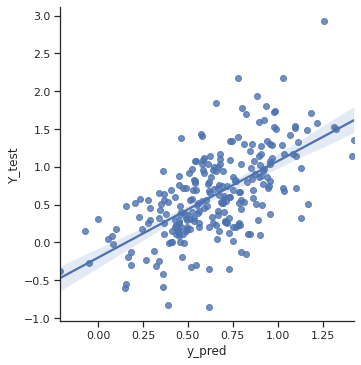

1
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
253
2-fold :  48.22134387351779
3-fold :  69.1699604743083
5-fold :  85.7707509881423
gmfe :  2.4816290492721693
mfe :  1.368038045784429
bias :  0.148883948447315
rmse  0.5245540775550872
r2  0.3457847531327217


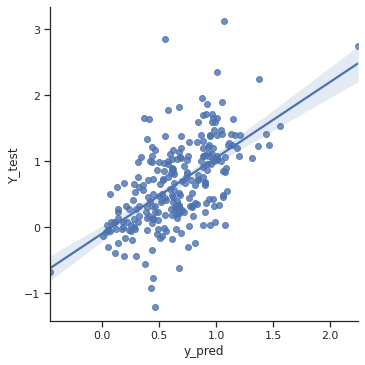

2
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
253
2-fold :  50.59288537549407
3-fold :  72.72727272727273
5-fold :  89.32806324110672
gmfe :  2.3509472246212235
mfe :  1.338128727530035
bias :  0.38905244347531465
rmse  0.49026127589274104
r2  0.3315863205712909


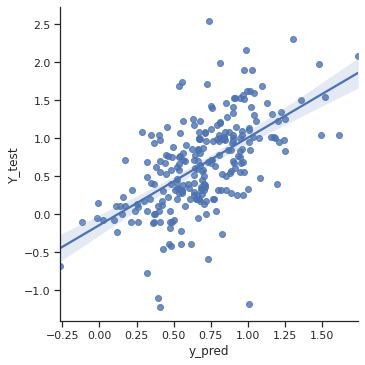

3
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
253
2-fold :  49.01185770750988
3-fold :  67.98418972332016
5-fold :  83.399209486166
gmfe :  2.5850757238634596
mfe :  1.3666254583125526
bias :  0.20101466204946594
rmse  0.5547814018475322
r2  0.2935057738095642


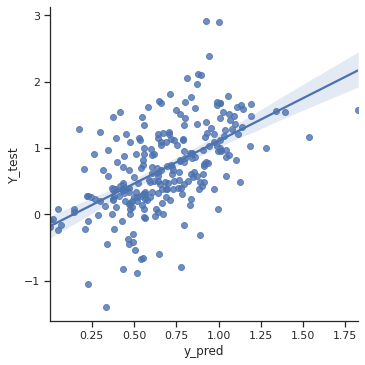

4
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
253
2-fold :  47.82608695652174
3-fold :  68.37944664031622
5-fold :  84.18972332015811
gmfe :  2.548366490178015
mfe :  1.3717362434025455
bias :  -0.2907893333625997
rmse  0.548539595614224
r2  0.24368844109746557


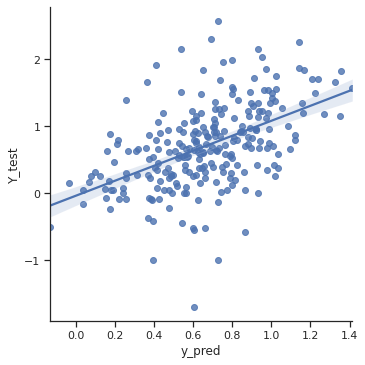

0
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  46.24505928853755
3-fold :  71.14624505928853
5-fold :  84.58498023715416
gmfe :  2.4986213928827503
mfe :  1.3838230565767549
bias :  0.1901549649644152
rmse  0.5315099417463494
r2  0.27698698009753375


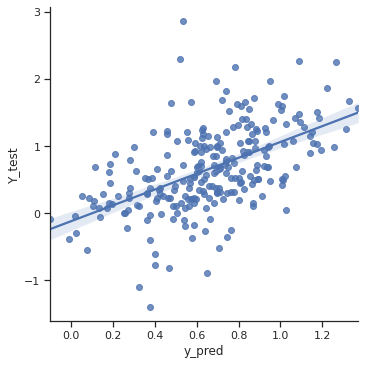

1
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
253
2-fold :  49.40711462450593
3-fold :  73.91304347826086
5-fold :  86.95652173913044
gmfe :  2.3619212931037334
mfe :  1.3576713731855747
bias :  0.19825514956676038
rmse  0.48299636739981777
r2  0.28406712596804806


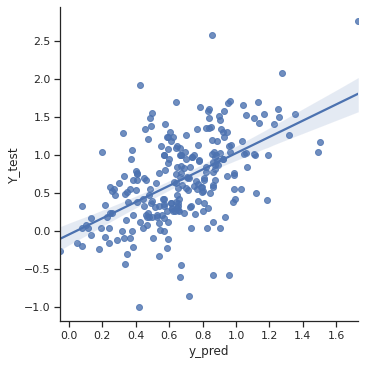

2
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
253
2-fold :  54.1501976284585
3-fold :  72.33201581027669
5-fold :  85.37549407114624
gmfe :  2.485236376414795
mfe :  1.3283526930457321
bias :  -0.3233231497851923
rmse  0.5485781128513268
r2  0.2729096252040891


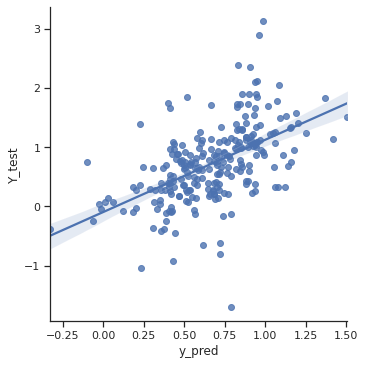

3
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  49.01185770750988
3-fold :  69.96047430830039
5-fold :  83.79446640316206
gmfe :  2.5039381742827684
mfe :  1.3574212692858236
bias :  0.2894879383966267
rmse  0.5316861893646397
r2  0.3273191602523383


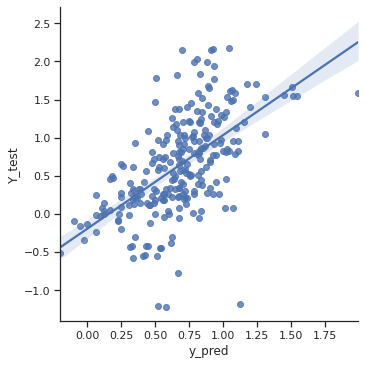

4
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  47.82608695652174
3-fold :  68.77470355731225
5-fold :  85.7707509881423
gmfe :  2.4293596543589655
mfe :  1.3627573528832122
bias :  0.14022246922691073
rmse  0.49886929393267215
r2  0.3553518165710201


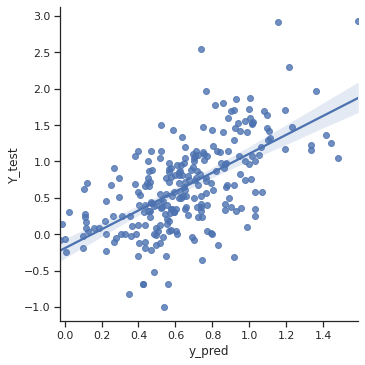

0
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
253
2-fold :  46.6403162055336
3-fold :  67.98418972332016
5-fold :  84.58498023715416
gmfe :  2.5457351672574844
mfe :  1.3853708805293676
bias :  -0.24769720002407425
rmse  0.5417837753413944
r2  0.22945970999855358


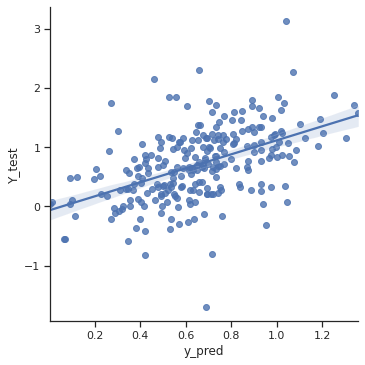

1
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  54.54545454545454
3-fold :  73.91304347826086
5-fold :  88.53754940711462
gmfe :  2.2716804306954406
mfe :  1.3102672662286432
bias :  0.15400783654961625
rmse  0.4687121836320972
r2  0.3175969071374166


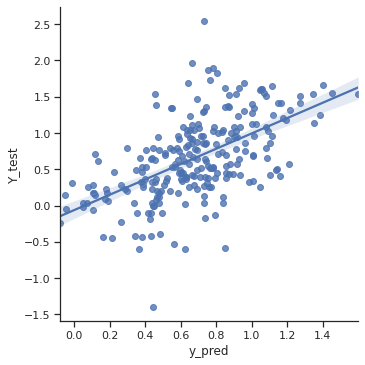

2
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  51.77865612648221
3-fold :  73.51778656126481
5-fold :  86.16600790513834
gmfe :  2.3457957906891895
mfe :  1.341699720732716
bias :  0.3098116065637728
rmse  0.4977558624163396
r2  0.3251510225872877


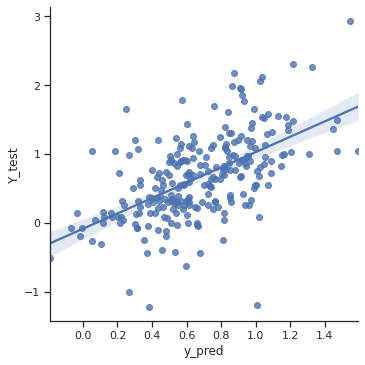

3
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  45.8498023715415
3-fold :  69.1699604743083
5-fold :  83.79446640316206
gmfe :  2.5845639299527683
mfe :  1.3780537323466004
bias :  0.37290656805810785
rmse  0.5518628026214912
r2  0.3444993828400601


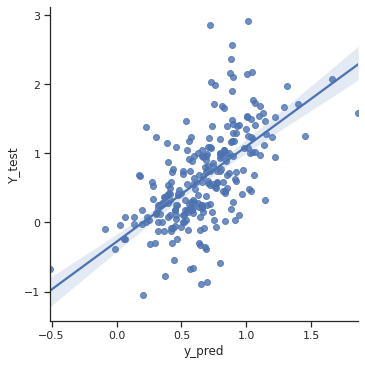

4
(1012, 161)
(253, 161)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  48.616600790513836
3-fold :  69.1699604743083
5-fold :  85.7707509881423
gmfe :  2.5079508011065568
mfe :  1.35610778177871
bias :  -0.04192737244872524
rmse  0.5298272237094882
r2  0.30536689108271853


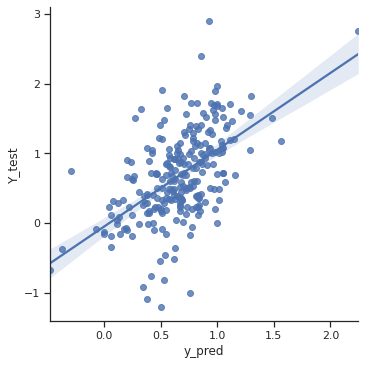

In [22]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo_mfp_Mordred_animal
    features = features_mfp_animal_columns
    baseline=10.00

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_mfp_withanimaldata_artificial_model.sav",  'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])


In [23]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           200         sqrt   
1    human_VDss_L_kg            42      1           200         sqrt   
2    human_VDss_L_kg            42      2           300         sqrt   
3    human_VDss_L_kg            42      3           300         sqrt   
4    human_VDss_L_kg            42      4           300         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           300         sqrt   
121      human_thalf            46      1           300         sqrt   
122      human_thalf            46      2           300         sqrt   
123      human_thalf            46      3           300         sqrt   
124      human_thalf            46      4           300         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    4         15      False  
1                    2         15      False  
2                    2         15      False  
3                    2         15      False  
4                    4         15      False  
..                 ...        ...        ...  
120                  4         15      False  
121                  2         15      False  
122                  2         15      False  
123                  2         15      False  
124                  2         15      False  

[125 rows x 8 columns]

In [24]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                           "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.556693  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.079143 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.729571 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.270267  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c... -0.002654  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.827116  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.575094  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.756880 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.997702  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.832430  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [25]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  55.200000  75.600000   
1    HeldOut  human_VDss_L_kg            42      1  59.200000  75.200000   
2    HeldOut  human_VDss_L_kg            42      2  61.200000  72.400000   
3    HeldOut  human_VDss_L_kg            42      3  54.400000  75.600000   
4    HeldOut  human_VDss_L_kg            42      4  57.831325  79.919679   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  46.640316  67.984190   
121  HeldOut      human_thalf            46      1  54.545455  73.913043   
122  HeldOut      human_thalf            46      2  51.778656  73.517787   
123  HeldOut      human_thalf            46      3  45.849802  69.169960   
124  HeldOut      human_thalf            46      4  48.616601  69.169960   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    89.200000  2.145500  1.297695  0.011260  0.433816  0.563822  
1    89.600000  2.059016  1.262630  0.075578  0.412253  0.544781  
2    85.600000  2.225037  1.246723  0.008338  0.483279  0.462313  
3    88.000000  2.125837  1.289601 -0.005850  0.432769  0.552797  
4    89.959839  2.128360  1.299876  0.073963  0.429381  0.522146  
..         ...       ...       ...       ...       ...       ...  
120  84.584980  2.545735  1.385371 -0.247697  0.541784  0.229460  
121  88.537549  2.271680  1.310267  0.154008  0.468712  0.317597  
122  86.166008  2.345796  1.341700  0.309812  0.497756  0.325151  
123  83.794466  2.584564  1.378054  0.372907  0.551863  0.344499  
124  85.770751  2.507951  1.356108 -0.041927  0.529827  0.305367  

[125 rows x 12 columns]

In [26]:
model_parameters.to_csv("model_parameters_Prediction_human_from_morgan_fs_animal_artificial.csv", index=False)

In [27]:
detail_list.to_csv("detail_list_Prediction_human_from_morgan_fs_animal_artificial.csv", index=False)

In [28]:
results.to_csv("Prediction_human_from_morgan_fs_animal_artificial.csv", index=False)

In [29]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_morgan_fs_animal_artificial.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_with_mfp_animal_artificial.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  51.147860  70.412512  85.152177   
human_VDss_L_kg             44.0    2.0  57.471036  75.838651  88.856610   
human_fup                   44.0    2.0  55.334416  67.895195  77.837792   
human_mrt                   44.0    2.0  49.347973  69.236235  83.748413   
human_thalf                 44.0    2.0  49.486166  70.988142  85.754941   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.481348  1.337773 -0.261668  0.537513  0.309582  
human_VDss_L_kg     2.132148  1.283111  0.026820  0.438298  0.528649  
human_fup           2.773724  1.282819  0.043036  0.211613  0.610868  
human_mrt           2.520249  1.359545  0.042833  0.541483  0.282103  
human_thalf         2.446533  1.355698  0.107191  0.516296  0.309835

In [30]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_mfp_withanimaldata_artificial_model.sav", 'rb'))